# MODELADO UTILIZANDO DEEP LEARNING CON KERAS v2

## CON SUBSAMPLING PARA REDUCIR EL NUMERO DE ROWS

Referencias sub-sampling:
* https://www.kdnuggets.com/2019/05/sample-huge-dataset-machine-learning.html
* https://www.polarmicrobes.org/how-i-learned-to-stop-worrying-and-love-subsampling-rarifying/
* https://freakonometrics.hypotheses.org/2133

Referencia modelado con Keras DL: 
* https://www.tensorflow.org/tutorials/keras/basic_regression
* https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
* https://keras.io/layers/core/

Referencia "DNN for Regression": https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [1]:
#Importamos las librerías que necesitaremos
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error
import numpy as np

In [2]:
## FUNCIONES QUE UTILIZARÉ

#Función para graficar la dispersión de las predicciones
def graf_disp():
    #Gráfica AZIMUT
    plt.figure(figsize=(12,5))
    plt.title("Dispersión de las predicciones Muon-Azimut", size=20)
    plt.xlabel('Valores Verdaderos')
    plt.ylabel('Predicciones')
    plt.scatter(Y_test.iloc[:,0],y_predict[:,0], c="green",label="predicciones")
    _ = plt.plot(Y_test.iloc[:,0],Y_test.iloc[:,0],c="gray",label="recta real")
    #plt.ylim(-5,5)
    plt.legend()
    plt.show()
    #Gráfica ZENIT
    plt.figure(figsize=(12,5))
    plt.title("Dispersión de las predicciones Muon-Zenit", size=20)
    plt.xlabel('Valores Verdaderos')
    plt.ylabel('Predicciones')
    plt.scatter(Y_test.iloc[:,1],y_predict[:,1], c="gray",label="predicciones")
    #plt.scatter(Y_test.iloc[:,1],Y_test.iloc[:,1],c="red",label="recta real")
    _ = plt.plot(Y_test.iloc[:,1],Y_test.iloc[:,1],c="red",label="recta real")
    plt.legend()
    plt.show()
    
#Esta función nos permite graficar el MAE y MSE vs las épocas 
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
  fig.suptitle("ERRORES VS EPOCAS", size=20, y=1.05)
  ax1.set_title("MAE vs Epocas", size=15)
  ax1.set_xlabel('Epoca', size=14)
  ax1.set_ylabel('Mean Absolute Error', size=12)
  ax1.plot(hist['epoch'], hist['mean_absolute_error'],label='Error de Entrenamiento')
  ax1.plot(hist['epoch'], hist['val_mean_absolute_error'],label ='Error de Validación')
  plt.ylim([0,10])
  ax1.legend()
  ax2.set_title("MSE vs Epocas", size=15)
  ax2.set_xlabel('Epoca', size=14)
  ax2.set_ylabel('Mean Squared Error', size=12)
  ax2.plot(hist['epoch'], hist['mean_squared_error'],label='Error de Entrenamiento')
  ax2.plot(hist['epoch'], hist['val_mean_squared_error'],label ='Error de Validación')
  plt.ylim([0,10])
  ax2.legend()
  plt.tight_layout()
  plt.show()
    
#Función para generar y comparar algunas predicciones vs valores reales
def gen_comp(n):
    print("Valores Predichos")
    print(y_predict[0:n])
    print("Valores Reales")
    print(Y_test.iloc[0:n].values)

#Función para calcular las métricas
def metricas(y_true,y_predict):
    mae = mean_absolute_error(y_true,y_predict)
    mse = mean_squared_error(y_true,y_predict)
    rmse = np.sqrt(mse)
    maxe= max_error(y_true,y_predict)
    mape = np.mean(np.abs((y_true-y_predict)/y_true)) * 100
    return(mae,mse,rmse,mape,maxe)

#Programa (clase) para imprimir puntos a la hora de ejecutar las épocas
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


In [3]:
#Ubicamos el dataset
#path = "Z:\MASTER INT. ARTIFICIAL\TFM_DATA\CLEANDATA\\" # Path PC Desktop en casa
#path = "U:\MASTER INT. ARTIFICIAL\TFM_DATA\CLEANDATA\\" # Path Laptop en casa
path = "F:\\DATA_TFM\\CLEANDATA\\" #Path PC Desktop en el trabajo
archivo = "dataset_completo.csv"

In [4]:
#Cargamos el dataset y leemos todo, para despues hacer subsampling
#raw_dataset = pd.read_csv(path+archivo, usecols=['lin_det', 'piso_det', 'mód_opt', 'X\'', 'Y\'', 'Z\'', 'azimut', 'zenit',
#                                                 'aafit_azimut', 'aafit_zenit','aafit_lambda', 'aafit_beta','bbfit_azimut',
#                                                 'bbfit_zenit','bbfit_quality', 'muon_azimut', 'muon_zenit'])#,nrows=10000)

In [5]:
### OPCION ORIGINAL PARA CARGAR EL DATASET PERO NO LA USE PORQUE HAY FEATURES (COLUMNAS) QUE ME PARECE QUE NO APORTAN NADA

#Cargamos el dataset y leemos todo, para despues hacer sumsampling
raw_dataset = pd.read_csv(path+archivo, usecols=['lin_det', 'piso_det', 'mód_opt', 'X\'', 'Y\'', 'Z\'', 'azimut', 'zenit',
                                             'tiempo', 't_selp', 'amp', 'frec_hits', 'aafit_azimut', 'aafit_zenit',
                                             'aafit_lambda', 'aafit_beta', 'bbfit_azimut', 'bbfit_zenit',
                                             'bbfit_quality', 'muon_azimut', 'muon_zenit'])#,nrows=10000)

In [6]:
#Realizamos el subsampling con n líneas
n=10000
rs=10
dataset = raw_dataset.sample(n, random_state=rs)
del raw_dataset #Borramos la anterior lista para liberar memoria
dataset.tail() #Mostramos como quedó el dataset

,lin_det,piso_det,mód_opt,X',Y',Z',azimut,zenit,tiempo,t_selp,...,frec_hits,aafit_azimut,aafit_zenit,aafit_lambda,aafit_beta,bbfit_azimut,bbfit_zenit,bbfit_quality,muon_azimut,muon_zenit
15675186,7,7,2,-35.477413,-15.095539,-83.514434,0.538065,2.356193,1111.213250,1111.213250,...,50.468445,-2.642994,1.581161,-6.514552,0.027619,-2.651094,1.606897,4.106721,-2.844497,1.626004
21153715,2,4,2,76.790921,57.827525,-127.803434,0.693055,2.356193,92.582143,92.582143,...,61.340332,-2.926584,1.357088,-5.881519,0.015498,-9.424778,1.306323,3.240517,-2.638245,1.583089
28343538,8,14,1,11.373284,-38.394692,18.272566,1.627880,2.356193,1112.395753,1059.810683,...,76.045990,0.134690,0.395073,-5.372895,0.007043,0.202409,0.378380,10.799513,0.115643,0.393628
22594244,7,15,0,-35.435291,-15.601902,32.677566,-0.372216,2.356193,1157.436781,1340.446590,...,148.773193,-2.230288,2.568302,-6.122077,0.007134,-2.174362,2.496019,4.713932,-2.167388,2.598427
25642591,4,4,0,44.390199,9.480367,-127.931434,-3.041185,2.356193,1400.076371,971.495534,...,53.329468,-1.216813,1.246325,-5.569547,0.011330,-1.561102,0.666758,16.605148,-1.688086,1.304435


C:\Users\Marco\Anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


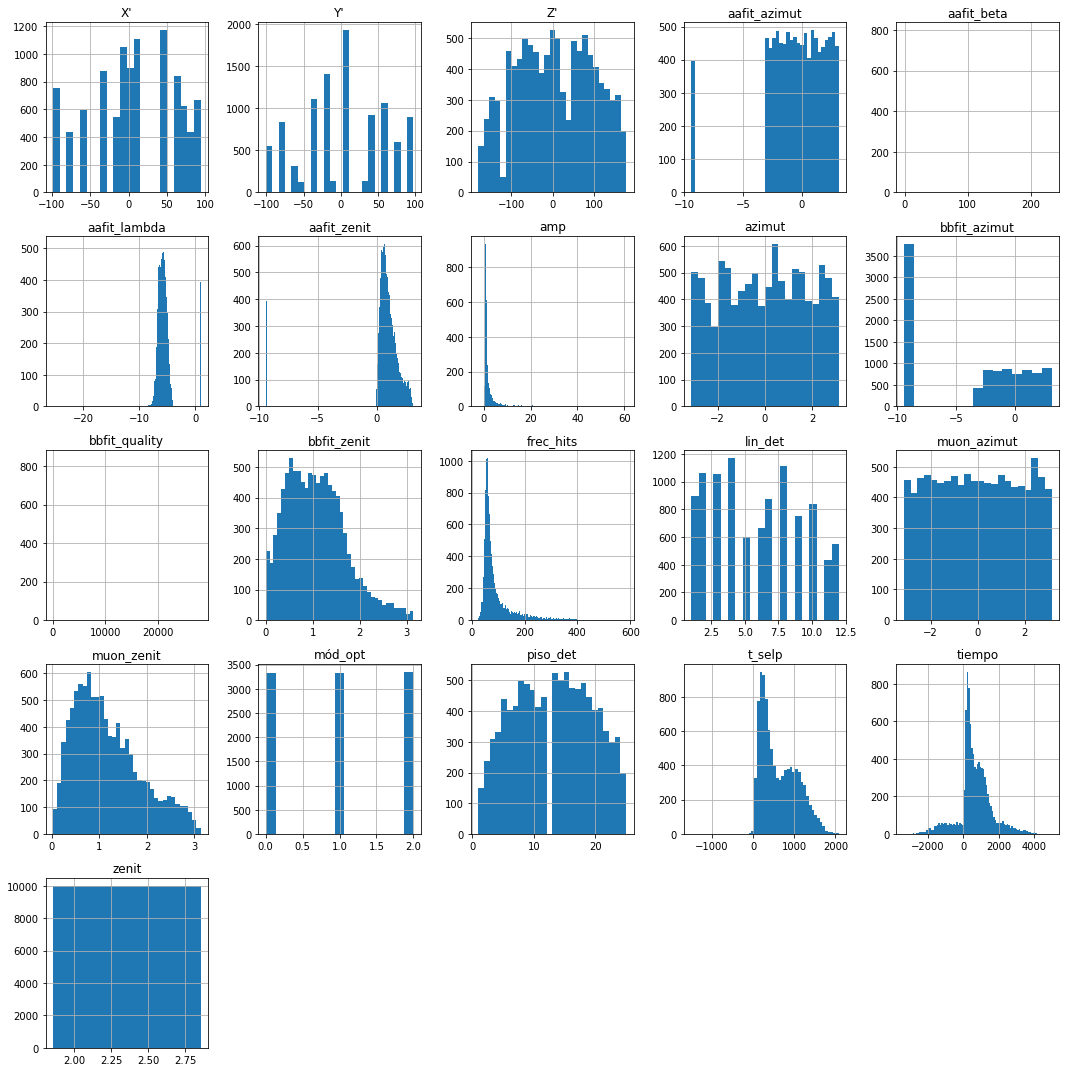

In [7]:
#Graficamos los histogramas de cada variable. (Tarda bastante...varios minutos)
fig = plt.figure(figsize= (15,15))
ax = fig.gca()
dataset.hist(ax=ax,bins='auto')
plt.tight_layout()
plt.show()

In [8]:
### DIVISION DE LA DATA EN TRAIN Y TEST PARA VALIDACIÓN HOLD-OUT INICIAL (VALIDACIÓN ANIDADA AL FINAL)
X = dataset.iloc[:,:19]; Y = dataset.iloc[:,19:21]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rs)

train_dataset = X_train
test_dataset = X_test
train_labels = Y_train
test_labels = Y_test

In [9]:
#Añadimos la visualización de unas cuantas filas (instancias) del dataset, unicamente de los "features" 
X.head()

,lin_det,piso_det,mód_opt,X',Y',Z',azimut,zenit,tiempo,t_selp,amp,frec_hits,aafit_azimut,aafit_zenit,aafit_lambda,aafit_beta,bbfit_azimut,bbfit_zenit,bbfit_quality
11180669,3,23,2,-10.041045,36.591821,148.119108,-1.688516,2.356193,1376.522822,1290.362146,2.473027,89.988708,-1.787907,2.412806,-5.958030,0.021088,-1.011551,2.376079,22.785874
27778481,10,19,2,59.683813,-78.106867,90.737566,2.365605,2.356193,1161.098171,1161.098171,0.483112,242.614746,1.881282,3.137666,-6.466947,0.004736,-9.424778,2.858024,7.001246
60244219,8,4,1,11.955500,-39.151662,-126.958434,-0.316710,2.356193,100.630024,59.675557,12.839453,62.961578,2.007390,1.028955,-5.454602,0.031032,1.822214,1.106519,3.652028
37899858,9,5,1,-93.941661,9.138795,-113.065434,0.893759,2.356193,231.406160,231.406160,0.968034,58.937073,1.797113,0.436611,-7.021642,0.061519,-9.424778,0.923388,4.216153
26812515,8,8,0,11.900501,-38.671965,-68.827434,0.545170,2.356193,235.694191,229.994833,2.232495,61.435699,-1.574157,0.680321,-6.126993,0.007682,-9.424778,0.509329,0.842094


In [10]:
#Añadimos la visualización de unas cuantas filas (instancias) del dataset, unicamente de los "outputs" 
Y.head()

,muon_azimut,muon_zenit
11180669,-1.999370,2.295454
27778481,-1.011663,2.891106
60244219,2.020555,1.029151
37899858,-1.384824,1.492530
26812515,-1.098321,0.848974


In [11]:
#Visualizando las estadísticas del conjunto de entrenamiento (features)
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lin_det,7000.0,5.889143,3.298503e+00,1.000000,3.000000,6.000000,9.000000,12.000000
piso_det,7000.0,13.171429,6.401041e+00,1.000000,8.000000,13.000000,18.000000,25.000000
mód_opt,7000.0,0.999857,8.165841e-01,0.000000,0.000000,1.000000,2.000000,2.000000
X',7000.0,7.444064,5.459588e+01,-98.410729,-35.477423,4.819282,59.529657,93.934807
Y',7000.0,4.404381,5.511363e+01,-101.017553,-38.883251,8.899396,56.715401,97.285109
Z',7000.0,4.902654,9.284525e+01,-180.034434,-69.529434,3.622566,76.218566,177.946108
azimut,7000.0,-0.005702,1.792573e+00,-3.119675,-1.556330,0.050360,1.524810,3.128265
zenit,7000.0,2.356193,4.441209e-16,2.356193,2.356193,2.356193,2.356193,2.356193
tiempo,7000.0,642.958139,9.592586e+02,-2950.127817,214.713113,543.055464,1125.407723,4094.922837
t_selp,7000.0,629.069083,4.362374e+02,-1501.918534,255.499185,504.926747,968.375142,2084.398824


In [12]:
#Visualizando las estadísticas del conjunto de entrenamiento (outputs)
train_labels.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
muon_azimut,7000.0,-0.001850,1.809883,-3.139295,-1.579825,-0.018814,1.571430,3.141137
muon_zenit,7000.0,1.175574,0.701572,0.020394,0.624730,1.035087,1.611884,3.096046


In [13]:
#Visualizando las estadísticas del conjunto de prueba (features)
test_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lin_det,3000.0,6.042667,3.363126,1.000000,3.000000,6.000000,9.000000,12.000000
piso_det,3000.0,13.094000,6.409227,1.000000,8.000000,13.000000,18.000000,25.000000
mód_opt,3000.0,1.008667,0.816178,0.000000,0.000000,1.000000,2.000000,2.000000
X',3000.0,6.542082,54.398588,-98.406270,-35.468594,4.775327,59.519716,93.934807
Y',3000.0,2.357404,56.195941,-101.032169,-39.151662,8.742069,56.447842,97.285109
Z',3000.0,3.799821,92.914699,-171.519434,-69.777892,3.622066,76.214566,177.946108
azimut,3000.0,0.073500,1.791599,-3.119675,-1.503265,0.165835,1.560330,3.128265
zenit,3000.0,2.356193,0.000000,2.356193,2.356193,2.356193,2.356193,2.356193
tiempo,3000.0,655.869636,960.493143,-3367.377155,216.274348,562.617679,1124.799242,4988.397927
t_selp,3000.0,631.555287,436.248333,-1227.519849,257.494934,508.694708,981.260373,1984.479526


In [14]:
#Visualizando las estadísticas del conjunto de prueba (outputs)
test_labels.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
muon_azimut,3000.0,0.020925,1.814519,-3.139821,-1.550138,0.018263,1.603256,3.139282
muon_zenit,3000.0,1.167540,0.702533,0.047963,0.618125,1.027119,1.582827,3.131667


## MODELADO "DEEP LEARNING", DE TIPO MULTI-OUTPUT

<font size=3>En este caso nos sirve la division de train y test previa. 

Utilizaremos el numero de capas obtenido y calculado de la referencia siguiente: http://dstath.users.uth.gr/papers/IJRS2009_Stathakis.pdf</font>

In [15]:
#Construyendo el modelo, tener en cuenta la longitud debe ser correcta de salida

#Función que nos ayuda a construir modelos de D.L. para regresión con Kerashttp://dstath.users.uth.gr/papers/IJRS2009_Stathakis.pdf
#Este modelo tiene unas capas con una cantidad de nodos "baja"
def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(1024, activation=tf.nn.relu),
        layers.Dense(512, activation=tf.nn.relu),
        layers.Dense(2)
    ])
    opt = tf.keras.optimizers.RMSprop(0.001) #Revisar si hay que aumentarlo o disminuirlo!!!, ¿menor o mayor learning rate?
    model.compile(loss='mean_squared_error', optimizer = opt, metrics=['mean_absolute_error','mean_squared_error'])
    return model

In [16]:
#Construyendo el modelo
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [17]:
#Viendo el resumen (capas y parámetros) del modelo
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               10240     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 1,061,378
Trainable params: 1,061,378
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Probando si la salida del modelo es del "shape" esperado
example_batch = train_dataset[:5]
result = model.predict(example_batch)

In [19]:
#Viendo el "batch" de ejemplo
example_batch

,lin_det,piso_det,mód_opt,X',Y',Z',azimut,zenit,tiempo,t_selp,amp,frec_hits,aafit_azimut,aafit_zenit,aafit_lambda,aafit_beta,bbfit_azimut,bbfit_zenit,bbfit_quality
20761713,5,19,1,-57.807253,78.556881,89.978566,-0.071791,2.356193,411.210397,411.210397,4.725892,106.430054,2.758065,0.576869,-6.003856,0.012766,1.717574,1.375544,2.674706
14060300,1,3,0,4.924304,96.385746,-150.969892,0.191450,2.356193,847.105915,582.624842,1.733741,81.806183,-0.587664,0.950911,-5.299235,0.019762,-0.665374,0.737375,9.349486
46488793,2,19,0,76.805180,57.809734,90.170566,0.653550,2.356193,267.968618,266.191393,0.732691,68.988800,-2.512457,1.358967,-4.884430,0.005409,-2.691540,1.356323,2.269718
40236418,1,10,0,4.704033,97.169995,-49.279434,0.925251,2.356193,778.822072,778.822072,0.497820,78.601837,-0.918506,0.080013,-5.093677,0.004162,-9.424778,0.077017,0.445980
22099883,2,23,1,76.793383,57.824539,148.291566,0.686250,2.356193,740.708892,740.708892,3.062962,152.530670,-1.920790,2.896045,-5.912392,0.007524,-2.100266,2.895553,0.558131


In [20]:
#"Observando" la "forma" de la salida del modelo prediciendo (aun sin entrenar)
#solo queremos verificar que la "forma" de salida sea la correcta
result

array([[27.11309  ,  6.5951424],
       [52.28658  , 29.355251 ],
       [12.360134 ,  3.3501105],
       [51.696857 , 26.91602  ],
       [36.200787 , 13.743174 ]], dtype=float32)

In [21]:
# Realizando el proceso de entrenamiento e imprimiendo un punto por cada epoca usando "callbacks"
EPOCHS = 100
#Entrenamos el modelo, el verbose se puede cambiar a uno si lo deseamos para visualizar mas a detalle el proceso
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split = 0.3, verbose=1, callbacks=[PrintDot()])

Train on 4900 samples, validate on 2100 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4900/4900 [==============================] - 1s 166us/sample - loss: 4127.5426 - mean_absolute_error: 13.0498 - mean_squared_error: 4127.5439 - val_loss: 25.4841 - val_mean_absolute_error: 1.7144 - val_mean_squared_error: 25.4841
Epoch 2/100
4900/4900 [==============================] - 1s 125us/sample - loss: 26.7949 - mean_absolute_error: 1.8348 - mean_squared_error: 26.7949 - val_loss: 17.3081 - val_mean_absolute_error: 1.4443 - val_mean_squared_error: 17.3081
Epoch 3/100
4900/4900 [==============================] - 1s 123us/sample - loss: 54.6224 - mean_absolute_error: 1.4164 - mean_squared_error: 54.6224 - val_loss: 2.2051 - val_mean_absolute_error: 1.1372 - val_mean_squared_error: 2.2051
Epoch 4/100
4900/4900 [==============================] - 1s 119us/sample - loss: 4.4630 - mean_absolute_error: 1.1968 - mean_squared_error: 4.4630 - val_loss: 2.4470 - val_mean_absolute_erro

4900/4900 [==============================] - 1s 118us/sample - loss: 0.8239 - mean_absolute_error: 0.5932 - mean_squared_error: 0.8239 - val_loss: 1.5271 - val_mean_absolute_error: 0.8463 - val_mean_squared_error: 1.5271
Epoch 70/100
4900/4900 [==============================] - 1s 118us/sample - loss: 0.7978 - mean_absolute_error: 0.5853 - mean_squared_error: 0.7978 - val_loss: 1.2800 - val_mean_absolute_error: 0.6757 - val_mean_squared_error: 1.2800
Epoch 71/100
4900/4900 [==============================] - 1s 127us/sample - loss: 0.8290 - mean_absolute_error: 0.5900 - mean_squared_error: 0.8290 - val_loss: 1.2642 - val_mean_absolute_error: 0.7066 - val_mean_squared_error: 1.2642
Epoch 72/100
4900/4900 [==============================] - 1s 122us/sample - loss: 0.7811 - mean_absolute_error: 0.5761 - mean_squared_error: 0.7811 - val_loss: 1.6536 - val_mean_absolute_error: 0.9136 - val_mean_squared_error: 1.6536
Epoch 73/100
4900/4900 [==============================] - 1s 116us/sample - l

In [22]:
#Guardamos el modelo ya entrenado y sus resultados en un DataFrama para análisis posterior
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,0.637308,0.508991,0.637307,1.789534,0.791652,1.789534,95
96,0.645692,0.514248,0.645692,2.166922,0.949882,2.166922,96
97,0.608648,0.506556,0.608648,1.766847,0.809891,1.766847,97
98,0.637383,0.517918,0.637383,1.556990,0.714977,1.556990,98
99,0.603316,0.497099,0.603316,1.389705,0.681647,1.389705,99


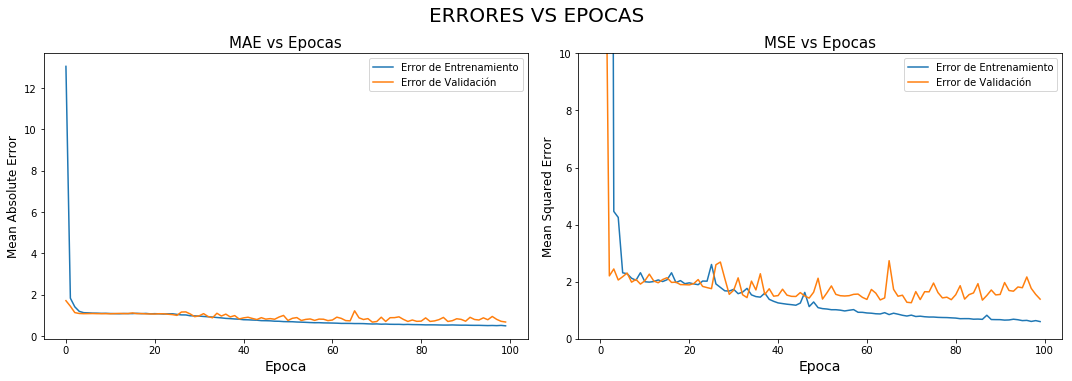

In [23]:
#Graficando MAE & MSE vs épocas
plot_history(history)

In [24]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.68
Mean Square Error, del conjunto de Test:  1.35


In [25]:
# Generando las predicciones
y_predict = model.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[-0.20404932  0.2845791 ]
 [ 0.9234071   1.1037295 ]
 [ 0.6577611   0.56129485]
 [-1.0169392   1.6315176 ]
 [-1.4371471   0.9956873 ]]
Valores Reales
[[-0.01410099  0.43851354]
 [ 0.90625105  0.74593764]
 [ 0.81327691  0.33611374]
 [-0.70962814  1.61685259]
 [-0.55983427  1.07146232]]


In [26]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.049288,0.308464
MSE,2.510910,0.186012
RMSE,1.584585,0.431291
MAPE,231.773661,46.296185
MAXE,7.385876,2.132969


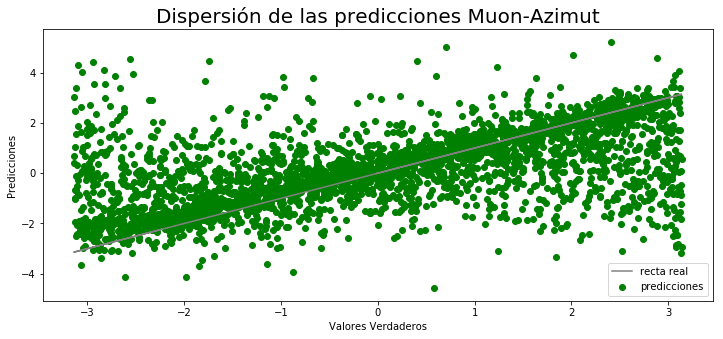

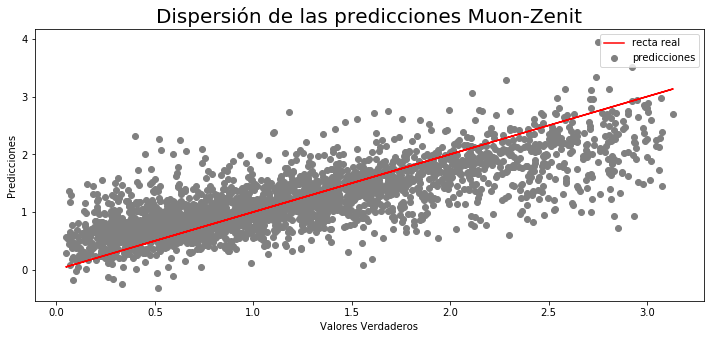

In [27]:
#Graficando las dispersiones
graf_disp()

<font size=4>Analizando esta red neuronal profunda con un número de nodos considerable y entrenada por 1000 épocas, vemos que los valores se ajustan mejor que en el algoritmo XGBoost.
De hecho muestran una tendencia a alinearse hacia la línea recta de valores reales.

Dado lo anterior es muy prometedora esta arquitectura, sin embargo los experimentos de entrenamiento son muy costosos en tiempo.
</font>

## Grabando el modelo obtenido

En este punto grabaremos el modelo de 1024 nodos y 2 capas intermedias, para posteriormente probar otro.

In [29]:
#Grabamos el modelo usando el metodo save de keras
## Si ya se realizó este proceso no es necesario repetirlo (como en este caso)
archivo = 'modelo_keras_dnn_mo_1024_29ago_100epochs.h5'
path = "F:\\DATA_TFM\\MODELOS\\" #Path PC del trabajo
filename = path+archivo

model.save(filename)

## ENTRENANDO EL MISMO MODELO CON 500 ÉPOCAS

In [30]:
# Realizando el proceso de entrenamiento e imprimiendo un punto por cada epoca usando "callbacks"
EPOCHS = 500
#Entrenamos el modelo, el verbose se puede cambiar a uno si lo deseamos para visualizar mas a detalle el proceso
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split = 0.3, verbose=1, callbacks=[PrintDot()])

Train on 4900 samples, validate on 2100 samples
Epoch 1/500
4900/4900 [==============================] - 1s 117us/sample - loss: 0.6151 - mean_absolute_error: 0.5056 - mean_squared_error: 0.6151 - val_loss: 1.7107 - val_mean_absolute_error: 0.8009 - val_mean_squared_error: 1.7107
Epoch 2/500
4900/4900 [==============================] - 1s 120us/sample - loss: 0.8027 - mean_absolute_error: 0.5081 - mean_squared_error: 0.8027 - val_loss: 1.6763 - val_mean_absolute_error: 0.7690 - val_mean_squared_error: 1.6763
Epoch 3/500
4900/4900 [==============================] - 1s 122us/sample - loss: 0.6845 - mean_absolute_error: 0.4962 - mean_squared_error: 0.6845 - val_loss: 1.4695 - val_mean_absolute_error: 0.7279 - val_mean_squared_error: 1.4695
Epoch 4/500
4900/4900 [==============================] - 1s 122us/sample - loss: 0.5861 - mean_absolute_error: 0.4885 - mean_squared_error: 0.5861 - val_loss: 1.5076 - val_mean_absolute_error: 0.7537 - val_mean_squared_error: 1.5076
Epoch 5/500
4900/490

4900/4900 [==============================] - 1s 126us/sample - loss: 0.3664 - mean_absolute_error: 0.3924 - mean_squared_error: 0.3664 - val_loss: 1.5800 - val_mean_absolute_error: 0.7806 - val_mean_squared_error: 1.5800
Epoch 71/500
4900/4900 [==============================] - 1s 130us/sample - loss: 0.3790 - mean_absolute_error: 0.3966 - mean_squared_error: 0.3790 - val_loss: 1.6019 - val_mean_absolute_error: 0.7817 - val_mean_squared_error: 1.6019
Epoch 72/500
4900/4900 [==============================] - 1s 127us/sample - loss: 0.3585 - mean_absolute_error: 0.3900 - mean_squared_error: 0.3585 - val_loss: 1.5657 - val_mean_absolute_error: 0.7479 - val_mean_squared_error: 1.5657
Epoch 73/500
4900/4900 [==============================] - 1s 124us/sample - loss: 0.3643 - mean_absolute_error: 0.3904 - mean_squared_error: 0.3643 - val_loss: 1.5927 - val_mean_absolute_error: 0.8015 - val_mean_squared_error: 1.5927
Epoch 74/500
4900/4900 [==============================] - 1s 119us/sample - l

Epoch 139/500
4900/4900 [==============================] - 1s 126us/sample - loss: 0.3078 - mean_absolute_error: 0.3393 - mean_squared_error: 0.3078 - val_loss: 1.4758 - val_mean_absolute_error: 0.7221 - val_mean_squared_error: 1.4758
Epoch 140/500
4900/4900 [==============================] - 1s 120us/sample - loss: 0.2699 - mean_absolute_error: 0.3367 - mean_squared_error: 0.2699 - val_loss: 1.5609 - val_mean_absolute_error: 0.7493 - val_mean_squared_error: 1.5609
Epoch 141/500
4900/4900 [==============================] - 1s 123us/sample - loss: 0.2646 - mean_absolute_error: 0.3336 - mean_squared_error: 0.2646 - val_loss: 1.6068 - val_mean_absolute_error: 0.7266 - val_mean_squared_error: 1.6068
Epoch 142/500
4900/4900 [==============================] - 1s 117us/sample - loss: 0.4048 - mean_absolute_error: 0.3327 - mean_squared_error: 0.4048 - val_loss: 1.5093 - val_mean_absolute_error: 0.7759 - val_mean_squared_error: 1.5093
Epoch 143/500
4900/4900 [==============================] - 1

Epoch 174/500
4900/4900 [==============================] - 1s 129us/sample - loss: 0.2575 - mean_absolute_error: 0.3123 - mean_squared_error: 0.2575 - val_loss: 1.4073 - val_mean_absolute_error: 0.7106 - val_mean_squared_error: 1.4073
Epoch 175/500
4900/4900 [==============================] - 1s 153us/sample - loss: 0.2384 - mean_absolute_error: 0.3169 - mean_squared_error: 0.2384 - val_loss: 1.4860 - val_mean_absolute_error: 0.7256 - val_mean_squared_error: 1.4860
Epoch 176/500
4900/4900 [==============================] - 1s 134us/sample - loss: 0.3725 - mean_absolute_error: 0.3120 - mean_squared_error: 0.3725 - val_loss: 1.5428 - val_mean_absolute_error: 0.7696 - val_mean_squared_error: 1.5428
Epoch 177/500
4900/4900 [==============================] - 1s 127us/sample - loss: 0.2294 - mean_absolute_error: 0.3132 - mean_squared_error: 0.2294 - val_loss: 1.4043 - val_mean_absolute_error: 0.7182 - val_mean_squared_error: 1.4043
Epoch 178/500
4900/4900 [==============================] - 1

Epoch 243/500
4900/4900 [==============================] - 1s 159us/sample - loss: 0.1909 - mean_absolute_error: 0.2896 - mean_squared_error: 0.1909 - val_loss: 1.4263 - val_mean_absolute_error: 0.7021 - val_mean_squared_error: 1.4263
Epoch 244/500
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1862 - mean_absolute_error: 0.2825 - mean_squared_error: 0.1862 - val_loss: 1.4842 - val_mean_absolute_error: 0.7031 - val_mean_squared_error: 1.4842
Epoch 245/500
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1818 - mean_absolute_error: 0.2830 - mean_squared_error: 0.1818 - val_loss: 1.5870 - val_mean_absolute_error: 0.7798 - val_mean_squared_error: 1.5870
Epoch 246/500
4900/4900 [==============================] - 1s 180us/sample - loss: 0.2178 - mean_absolute_error: 0.2872 - mean_squared_error: 0.2178 - val_loss: 1.5959 - val_mean_absolute_error: 0.7849 - val_mean_squared_error: 1.5959
Epoch 247/500
4900/4900 [==============================] - 1

Epoch 278/500
4900/4900 [==============================] - 1s 131us/sample - loss: 0.1781 - mean_absolute_error: 0.2804 - mean_squared_error: 0.1781 - val_loss: 1.5531 - val_mean_absolute_error: 0.7724 - val_mean_squared_error: 1.5531
Epoch 279/500
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1758 - mean_absolute_error: 0.2781 - mean_squared_error: 0.1758 - val_loss: 1.3820 - val_mean_absolute_error: 0.7019 - val_mean_squared_error: 1.3820
Epoch 280/500
4900/4900 [==============================] - 1s 123us/sample - loss: 0.1777 - mean_absolute_error: 0.2809 - mean_squared_error: 0.1777 - val_loss: 1.4163 - val_mean_absolute_error: 0.7187 - val_mean_squared_error: 1.4163
Epoch 281/500
4900/4900 [==============================] - 1s 131us/sample - loss: 0.1739 - mean_absolute_error: 0.2772 - mean_squared_error: 0.1739 - val_loss: 1.4168 - val_mean_absolute_error: 0.7367 - val_mean_squared_error: 1.4168
Epoch 282/500
4900/4900 [==============================] - 1

4900/4900 [==============================] - 1s 149us/sample - loss: 0.1533 - mean_absolute_error: 0.2618 - mean_squared_error: 0.1533 - val_loss: 1.3952 - val_mean_absolute_error: 0.7042 - val_mean_squared_error: 1.3952
Epoch 347/500
4900/4900 [==============================] - 1s 146us/sample - loss: 0.1525 - mean_absolute_error: 0.2591 - mean_squared_error: 0.1525 - val_loss: 1.3944 - val_mean_absolute_error: 0.6819 - val_mean_squared_error: 1.3945
Epoch 348/500
4900/4900 [==============================] - 1s 132us/sample - loss: 0.1531 - mean_absolute_error: 0.2592 - mean_squared_error: 0.1531 - val_loss: 1.3759 - val_mean_absolute_error: 0.6953 - val_mean_squared_error: 1.3759
Epoch 349/500
4900/4900 [==============================] - 1s 132us/sample - loss: 0.1423 - mean_absolute_error: 0.2565 - mean_squared_error: 0.1423 - val_loss: 1.4189 - val_mean_absolute_error: 0.7227 - val_mean_squared_error: 1.4189
Epoch 350/500
4900/4900 [==============================] - 1s 141us/sample

Epoch 381/500
4900/4900 [==============================] - 1s 121us/sample - loss: 0.1437 - mean_absolute_error: 0.2524 - mean_squared_error: 0.1437 - val_loss: 1.3185 - val_mean_absolute_error: 0.6819 - val_mean_squared_error: 1.3185
Epoch 382/500
4900/4900 [==============================] - 1s 141us/sample - loss: 0.1452 - mean_absolute_error: 0.2528 - mean_squared_error: 0.1452 - val_loss: 1.5958 - val_mean_absolute_error: 0.7728 - val_mean_squared_error: 1.5958
Epoch 383/500
4900/4900 [==============================] - 1s 133us/sample - loss: 0.1544 - mean_absolute_error: 0.2577 - mean_squared_error: 0.1544 - val_loss: 1.5156 - val_mean_absolute_error: 0.7511 - val_mean_squared_error: 1.5156
Epoch 384/500
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1488 - mean_absolute_error: 0.2557 - mean_squared_error: 0.1488 - val_loss: 1.3483 - val_mean_absolute_error: 0.7046 - val_mean_squared_error: 1.3483
Epoch 385/500
4900/4900 [==============================] - 1

Epoch 450/500
4900/4900 [==============================] - 1s 136us/sample - loss: 0.1367 - mean_absolute_error: 0.2458 - mean_squared_error: 0.1367 - val_loss: 1.4841 - val_mean_absolute_error: 0.7559 - val_mean_squared_error: 1.4841
Epoch 451/500
4900/4900 [==============================] - 1s 146us/sample - loss: 0.1379 - mean_absolute_error: 0.2498 - mean_squared_error: 0.1379 - val_loss: 1.4438 - val_mean_absolute_error: 0.7127 - val_mean_squared_error: 1.4438
Epoch 452/500
4900/4900 [==============================] - 1s 127us/sample - loss: 0.1370 - mean_absolute_error: 0.2496 - mean_squared_error: 0.1370 - val_loss: 1.4413 - val_mean_absolute_error: 0.7370 - val_mean_squared_error: 1.4413
Epoch 453/500
4900/4900 [==============================] - 1s 128us/sample - loss: 0.1349 - mean_absolute_error: 0.2463 - mean_squared_error: 0.1349 - val_loss: 1.4522 - val_mean_absolute_error: 0.7472 - val_mean_squared_error: 1.4522
Epoch 454/500
4900/4900 [==============================] - 1

Epoch 485/500
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1226 - mean_absolute_error: 0.2389 - mean_squared_error: 0.1226 - val_loss: 1.4365 - val_mean_absolute_error: 0.7148 - val_mean_squared_error: 1.4365
Epoch 486/500
4900/4900 [==============================] - 1s 126us/sample - loss: 0.1294 - mean_absolute_error: 0.2400 - mean_squared_error: 0.1294 - val_loss: 1.3222 - val_mean_absolute_error: 0.6833 - val_mean_squared_error: 1.3222
Epoch 487/500
4900/4900 [==============================] - 1s 128us/sample - loss: 0.1332 - mean_absolute_error: 0.2406 - mean_squared_error: 0.1332 - val_loss: 1.3957 - val_mean_absolute_error: 0.7546 - val_mean_squared_error: 1.3957
Epoch 488/500
4900/4900 [==============================] - 1s 123us/sample - loss: 0.1326 - mean_absolute_error: 0.2434 - mean_squared_error: 0.1326 - val_loss: 1.4525 - val_mean_absolute_error: 0.7258 - val_mean_squared_error: 1.4525
Epoch 489/500
4900/4900 [==============================] - 1

In [31]:
#Guardamos el modelo ya entrenado y sus resultados en un DataFrama para análisis posterior
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
495,0.131409,0.239055,0.131409,1.448837,0.712549,1.448837,495
496,0.122217,0.234229,0.122217,1.511906,0.705282,1.511906,496
497,0.129877,0.241779,0.129877,1.461705,0.740068,1.461705,497
498,0.151320,0.239477,0.151320,1.581233,0.733204,1.581233,498
499,0.126343,0.241080,0.126343,1.535966,0.743688,1.535966,499


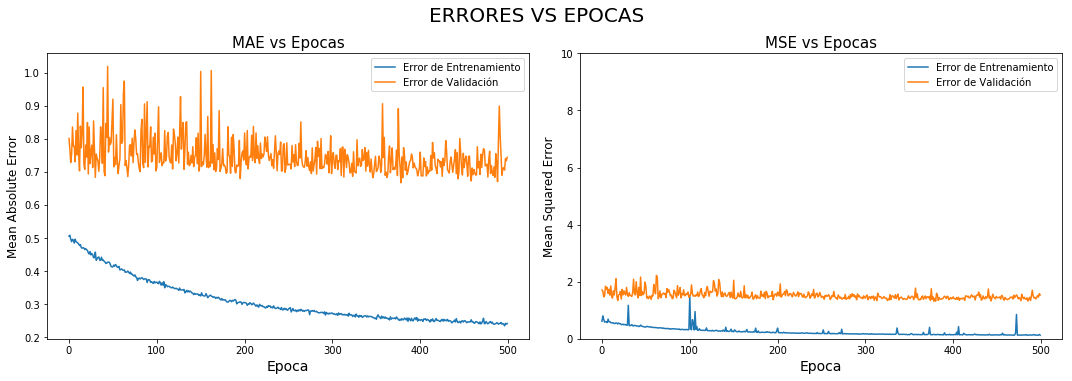

In [32]:
#Graficando MAE & MSE vs épocas
plot_history(history)

In [33]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.74
Mean Square Error, del conjunto de Test:  1.49


In [34]:
# Generando las predicciones
y_predict = model.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[-0.19161612  0.10701519]
 [ 1.1631647   1.1323459 ]
 [ 0.7054615   0.67921245]
 [-1.5680343   2.3733323 ]
 [-3.6582124   0.5449834 ]]
Valores Reales
[[-0.01410099  0.43851354]
 [ 0.90625105  0.74593764]
 [ 0.81327691  0.33611374]
 [-0.70962814  1.61685259]
 [-0.55983427  1.07146232]]


In [35]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.104567,0.380843
MSE,2.712212,0.262986
RMSE,1.646879,0.512822
MAPE,249.296916,50.894647
MAXE,9.062731,3.877696


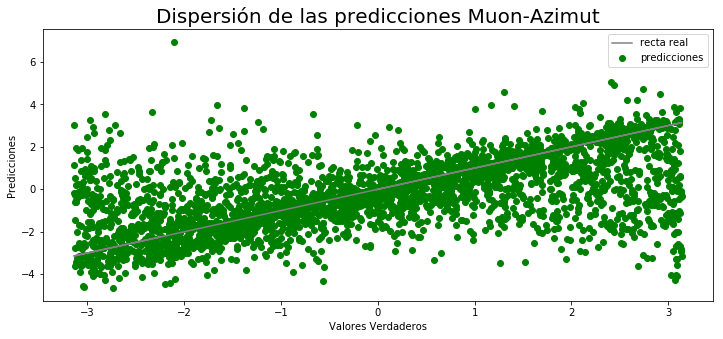

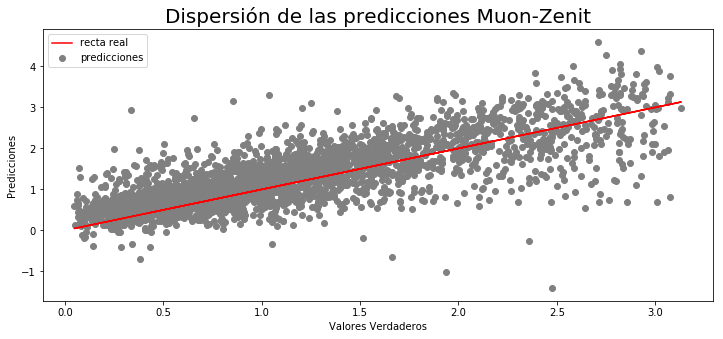

In [36]:
#Graficando las dispersiones
graf_disp()

In [37]:
#Grabamos el modelo usando el metodo save de keras
## Si ya se realizó este proceso no es necesario repetirlo
archivo = 'modelo_keras_dnn_mo_1024_29ago_500epochs.h5'
path = "F:\\DATA_TFM\\MODELOS\\" #Path PC del trabajo
filename = path+archivo

model.save(filename)

In [ ]:
## ENTRENANDO MISMO MODELO (1024) CON 3000 ÉPOCAS

In [38]:
# Realizando el proceso de entrenamiento e imprimiendo un punto por cada epoca usando "callbacks"
EPOCHS = 3000
#Entrenamos el modelo, el verbose se puede cambiar a uno si lo deseamos para visualizar mas a detalle el proceso
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split = 0.3, verbose=1, callbacks=[PrintDot()])

Train on 4900 samples, validate on 2100 samples
Epoch 1/3000
4900/4900 [==============================] - 1s 123us/sample - loss: 0.1428 - mean_absolute_error: 0.2449 - mean_squared_error: 0.1428 - val_loss: 1.5063 - val_mean_absolute_error: 0.7113 - val_mean_squared_error: 1.5063
Epoch 2/3000
4900/4900 [==============================] - 1s 125us/sample - loss: 0.1293 - mean_absolute_error: 0.2401 - mean_squared_error: 0.1293 - val_loss: 1.4994 - val_mean_absolute_error: 0.7153 - val_mean_squared_error: 1.4994
Epoch 3/3000
4900/4900 [==============================] - 1s 125us/sample - loss: 0.1541 - mean_absolute_error: 0.2438 - mean_squared_error: 0.1541 - val_loss: 1.5099 - val_mean_absolute_error: 0.7153 - val_mean_squared_error: 1.5099
Epoch 4/3000
4900/4900 [==============================] - 1s 124us/sample - loss: 0.1325 - mean_absolute_error: 0.2400 - mean_squared_error: 0.1325 - val_loss: 1.5249 - val_mean_absolute_error: 0.7113 - val_mean_squared_error: 1.5249
Epoch 5/3000
490

Epoch 70/3000
4900/4900 [==============================] - 1s 118us/sample - loss: 0.1204 - mean_absolute_error: 0.2307 - mean_squared_error: 0.1204 - val_loss: 1.5155 - val_mean_absolute_error: 0.7443 - val_mean_squared_error: 1.5155
Epoch 71/3000
4900/4900 [==============================] - 1s 128us/sample - loss: 0.1212 - mean_absolute_error: 0.2335 - mean_squared_error: 0.1212 - val_loss: 1.6054 - val_mean_absolute_error: 0.7690 - val_mean_squared_error: 1.6054
Epoch 72/3000
4900/4900 [==============================] - 1s 139us/sample - loss: 0.1190 - mean_absolute_error: 0.2360 - mean_squared_error: 0.1190 - val_loss: 1.5276 - val_mean_absolute_error: 0.7155 - val_mean_squared_error: 1.5276
Epoch 73/3000
4900/4900 [==============================] - 1s 136us/sample - loss: 0.1249 - mean_absolute_error: 0.2373 - mean_squared_error: 0.1249 - val_loss: 1.5018 - val_mean_absolute_error: 0.7167 - val_mean_squared_error: 1.5018
Epoch 74/3000
4900/4900 [==============================] - 1

Epoch 139/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1139 - mean_absolute_error: 0.2268 - mean_squared_error: 0.1139 - val_loss: 1.6188 - val_mean_absolute_error: 0.8259 - val_mean_squared_error: 1.6188
Epoch 140/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1197 - mean_absolute_error: 0.2332 - mean_squared_error: 0.1197 - val_loss: 1.6334 - val_mean_absolute_error: 0.7610 - val_mean_squared_error: 1.6334
Epoch 141/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1186 - mean_absolute_error: 0.2298 - mean_squared_error: 0.1186 - val_loss: 1.7496 - val_mean_absolute_error: 0.7155 - val_mean_squared_error: 1.7496
Epoch 142/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1164 - mean_absolute_error: 0.2316 - mean_squared_error: 0.1164 - val_loss: 1.5618 - val_mean_absolute_error: 0.7419 - val_mean_squared_error: 1.5618
Epoch 143/3000
4900/4900 [==============================

Epoch 174/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.1120 - mean_absolute_error: 0.2256 - mean_squared_error: 0.1120 - val_loss: 1.3936 - val_mean_absolute_error: 0.6715 - val_mean_squared_error: 1.3936
Epoch 175/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1182 - mean_absolute_error: 0.2311 - mean_squared_error: 0.1182 - val_loss: 1.6426 - val_mean_absolute_error: 0.7033 - val_mean_squared_error: 1.6426
Epoch 176/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1083 - mean_absolute_error: 0.2244 - mean_squared_error: 0.1083 - val_loss: 1.6116 - val_mean_absolute_error: 0.7755 - val_mean_squared_error: 1.6116
Epoch 177/3000
4900/4900 [==============================] - 1s 130us/sample - loss: 0.1191 - mean_absolute_error: 0.2320 - mean_squared_error: 0.1191 - val_loss: 1.7371 - val_mean_absolute_error: 0.7424 - val_mean_squared_error: 1.7371
Epoch 178/3000
4900/4900 [==============================

Epoch 243/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.1137 - mean_absolute_error: 0.2265 - mean_squared_error: 0.1137 - val_loss: 1.4606 - val_mean_absolute_error: 0.7011 - val_mean_squared_error: 1.4606
Epoch 244/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1131 - mean_absolute_error: 0.2260 - mean_squared_error: 0.1131 - val_loss: 1.4122 - val_mean_absolute_error: 0.6920 - val_mean_squared_error: 1.4122
Epoch 245/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1106 - mean_absolute_error: 0.2256 - mean_squared_error: 0.1106 - val_loss: 1.3922 - val_mean_absolute_error: 0.7342 - val_mean_squared_error: 1.3922
Epoch 246/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1103 - mean_absolute_error: 0.2257 - mean_squared_error: 0.1103 - val_loss: 1.6379 - val_mean_absolute_error: 0.8077 - val_mean_squared_error: 1.6379
Epoch 247/3000
4900/4900 [==============================

Epoch 278/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1155 - mean_absolute_error: 0.2316 - mean_squared_error: 0.1155 - val_loss: 1.4580 - val_mean_absolute_error: 0.6939 - val_mean_squared_error: 1.4580
Epoch 279/3000
4900/4900 [==============================] - 1s 139us/sample - loss: 0.1084 - mean_absolute_error: 0.2210 - mean_squared_error: 0.1084 - val_loss: 1.5744 - val_mean_absolute_error: 0.7987 - val_mean_squared_error: 1.5744
Epoch 280/3000
4900/4900 [==============================] - 1s 122us/sample - loss: 0.1138 - mean_absolute_error: 0.2292 - mean_squared_error: 0.1138 - val_loss: 1.4379 - val_mean_absolute_error: 0.7106 - val_mean_squared_error: 1.4379
Epoch 281/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1141 - mean_absolute_error: 0.2247 - mean_squared_error: 0.1141 - val_loss: 1.4804 - val_mean_absolute_error: 0.6857 - val_mean_squared_error: 1.4804
Epoch 282/3000
4900/4900 [==============================

Epoch 347/3000
4900/4900 [==============================] - 1s 117us/sample - loss: 0.1093 - mean_absolute_error: 0.2210 - mean_squared_error: 0.1093 - val_loss: 1.5230 - val_mean_absolute_error: 0.6920 - val_mean_squared_error: 1.5230
Epoch 348/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1142 - mean_absolute_error: 0.2281 - mean_squared_error: 0.1141 - val_loss: 1.4941 - val_mean_absolute_error: 0.6866 - val_mean_squared_error: 1.4941
Epoch 349/3000
4900/4900 [==============================] - 1s 134us/sample - loss: 0.1269 - mean_absolute_error: 0.2230 - mean_squared_error: 0.1269 - val_loss: 1.6179 - val_mean_absolute_error: 0.7513 - val_mean_squared_error: 1.6179
Epoch 350/3000
4900/4900 [==============================] - 1s 124us/sample - loss: 0.1105 - mean_absolute_error: 0.2240 - mean_squared_error: 0.1105 - val_loss: 1.6470 - val_mean_absolute_error: 0.7571 - val_mean_squared_error: 1.6470
Epoch 351/3000
4900/4900 [==============================

Epoch 382/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1114 - mean_absolute_error: 0.2245 - mean_squared_error: 0.1114 - val_loss: 1.5714 - val_mean_absolute_error: 0.7047 - val_mean_squared_error: 1.5714
Epoch 383/3000
4900/4900 [==============================] - 1s 126us/sample - loss: 0.1606 - mean_absolute_error: 0.2233 - mean_squared_error: 0.1606 - val_loss: 1.4430 - val_mean_absolute_error: 0.6893 - val_mean_squared_error: 1.4430
Epoch 384/3000
4900/4900 [==============================] - 1s 125us/sample - loss: 0.1080 - mean_absolute_error: 0.2214 - mean_squared_error: 0.1080 - val_loss: 1.5508 - val_mean_absolute_error: 0.6965 - val_mean_squared_error: 1.5508
Epoch 385/3000
4900/4900 [==============================] - 1s 125us/sample - loss: 0.1115 - mean_absolute_error: 0.2256 - mean_squared_error: 0.1115 - val_loss: 1.5745 - val_mean_absolute_error: 0.7197 - val_mean_squared_error: 1.5745
Epoch 386/3000
4900/4900 [==============================

Epoch 416/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1432 - mean_absolute_error: 0.2221 - mean_squared_error: 0.1432 - val_loss: 1.7466 - val_mean_absolute_error: 0.7180 - val_mean_squared_error: 1.7466
Epoch 417/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.1061 - mean_absolute_error: 0.2191 - mean_squared_error: 0.1061 - val_loss: 1.5114 - val_mean_absolute_error: 0.6926 - val_mean_squared_error: 1.5114
Epoch 418/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1094 - mean_absolute_error: 0.2246 - mean_squared_error: 0.1094 - val_loss: 1.6508 - val_mean_absolute_error: 0.7188 - val_mean_squared_error: 1.6508
Epoch 419/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.1064 - mean_absolute_error: 0.2227 - mean_squared_error: 0.1064 - val_loss: 1.6162 - val_mean_absolute_error: 0.7471 - val_mean_squared_error: 1.6162
Epoch 420/3000
4900/4900 [==============================

Epoch 451/3000
4900/4900 [==============================] - 1s 127us/sample - loss: 0.1145 - mean_absolute_error: 0.2236 - mean_squared_error: 0.1145 - val_loss: 1.8206 - val_mean_absolute_error: 0.7668 - val_mean_squared_error: 1.8206
Epoch 452/3000
4900/4900 [==============================] - 1s 121us/sample - loss: 0.1056 - mean_absolute_error: 0.2199 - mean_squared_error: 0.1056 - val_loss: 1.6452 - val_mean_absolute_error: 0.6946 - val_mean_squared_error: 1.6452
Epoch 453/3000
4900/4900 [==============================] - 1s 126us/sample - loss: 0.1095 - mean_absolute_error: 0.2181 - mean_squared_error: 0.1095 - val_loss: 1.6844 - val_mean_absolute_error: 0.7232 - val_mean_squared_error: 1.6844
Epoch 454/3000
4900/4900 [==============================] - 1s 127us/sample - loss: 0.1116 - mean_absolute_error: 0.2189 - mean_squared_error: 0.1116 - val_loss: 1.6595 - val_mean_absolute_error: 0.7613 - val_mean_squared_error: 1.6595
Epoch 455/3000
4900/4900 [==============================

Epoch 486/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1041 - mean_absolute_error: 0.2170 - mean_squared_error: 0.1041 - val_loss: 1.5258 - val_mean_absolute_error: 0.6896 - val_mean_squared_error: 1.5258
Epoch 487/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1060 - mean_absolute_error: 0.2199 - mean_squared_error: 0.1060 - val_loss: 1.5558 - val_mean_absolute_error: 0.6932 - val_mean_squared_error: 1.5558
Epoch 488/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1089 - mean_absolute_error: 0.2207 - mean_squared_error: 0.1089 - val_loss: 1.6178 - val_mean_absolute_error: 0.8144 - val_mean_squared_error: 1.6178
Epoch 489/3000
4900/4900 [==============================] - 1s 131us/sample - loss: 0.1055 - mean_absolute_error: 0.2189 - mean_squared_error: 0.1055 - val_loss: 1.6252 - val_mean_absolute_error: 0.7137 - val_mean_squared_error: 1.6252
Epoch 490/3000
4900/4900 [==============================

Epoch 555/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.0982 - mean_absolute_error: 0.2137 - mean_squared_error: 0.0982 - val_loss: 1.6321 - val_mean_absolute_error: 0.7541 - val_mean_squared_error: 1.6321
Epoch 556/3000
4900/4900 [==============================] - 1s 118us/sample - loss: 0.1046 - mean_absolute_error: 0.2164 - mean_squared_error: 0.1046 - val_loss: 1.5491 - val_mean_absolute_error: 0.6839 - val_mean_squared_error: 1.5491
Epoch 557/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1059 - mean_absolute_error: 0.2176 - mean_squared_error: 0.1059 - val_loss: 1.5908 - val_mean_absolute_error: 0.7333 - val_mean_squared_error: 1.5908
Epoch 558/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1004 - mean_absolute_error: 0.2132 - mean_squared_error: 0.1004 - val_loss: 1.6515 - val_mean_absolute_error: 0.7131 - val_mean_squared_error: 1.6515
Epoch 559/3000
4900/4900 [==============================

Epoch 590/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.1049 - mean_absolute_error: 0.2187 - mean_squared_error: 0.1049 - val_loss: 1.7319 - val_mean_absolute_error: 0.7588 - val_mean_squared_error: 1.7319
Epoch 591/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1019 - mean_absolute_error: 0.2186 - mean_squared_error: 0.1019 - val_loss: 1.7818 - val_mean_absolute_error: 0.7103 - val_mean_squared_error: 1.7818
Epoch 592/3000
4900/4900 [==============================] - 1s 117us/sample - loss: 0.1096 - mean_absolute_error: 0.2189 - mean_squared_error: 0.1096 - val_loss: 1.5396 - val_mean_absolute_error: 0.7061 - val_mean_squared_error: 1.5396
Epoch 593/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1005 - mean_absolute_error: 0.2157 - mean_squared_error: 0.1005 - val_loss: 1.6378 - val_mean_absolute_error: 0.7062 - val_mean_squared_error: 1.6378
Epoch 594/3000
4900/4900 [==============================

Epoch 659/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1007 - mean_absolute_error: 0.2141 - mean_squared_error: 0.1007 - val_loss: 1.6358 - val_mean_absolute_error: 0.7146 - val_mean_squared_error: 1.6358
Epoch 660/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1050 - mean_absolute_error: 0.2141 - mean_squared_error: 0.1050 - val_loss: 1.5639 - val_mean_absolute_error: 0.7080 - val_mean_squared_error: 1.5639
Epoch 661/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.0980 - mean_absolute_error: 0.2135 - mean_squared_error: 0.0980 - val_loss: 1.6367 - val_mean_absolute_error: 0.7317 - val_mean_squared_error: 1.6367
Epoch 662/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1062 - mean_absolute_error: 0.2187 - mean_squared_error: 0.1062 - val_loss: 1.5203 - val_mean_absolute_error: 0.7020 - val_mean_squared_error: 1.5203
Epoch 663/3000
4900/4900 [==============================

Epoch 694/3000
4900/4900 [==============================] - 1s 204us/sample - loss: 0.0987 - mean_absolute_error: 0.2124 - mean_squared_error: 0.0987 - val_loss: 1.6119 - val_mean_absolute_error: 0.6874 - val_mean_squared_error: 1.6119
Epoch 695/3000
4900/4900 [==============================] - 1s 165us/sample - loss: 0.1707 - mean_absolute_error: 0.2198 - mean_squared_error: 0.1707 - val_loss: 1.7414 - val_mean_absolute_error: 0.7451 - val_mean_squared_error: 1.7414
Epoch 696/3000
4900/4900 [==============================] - 1s 171us/sample - loss: 0.1008 - mean_absolute_error: 0.2158 - mean_squared_error: 0.1008 - val_loss: 1.6885 - val_mean_absolute_error: 0.6910 - val_mean_squared_error: 1.6885
Epoch 697/3000
4900/4900 [==============================] - 1s 173us/sample - loss: 0.1058 - mean_absolute_error: 0.2141 - mean_squared_error: 0.1058 - val_loss: 1.6581 - val_mean_absolute_error: 0.7162 - val_mean_squared_error: 1.6581
Epoch 698/3000
4900/4900 [==============================

4900/4900 [==============================] - 1s 118us/sample - loss: 0.0998 - mean_absolute_error: 0.2136 - mean_squared_error: 0.0998 - val_loss: 1.5463 - val_mean_absolute_error: 0.7742 - val_mean_squared_error: 1.5463
Epoch 763/3000
4900/4900 [==============================] - 1s 130us/sample - loss: 0.1032 - mean_absolute_error: 0.2171 - mean_squared_error: 0.1032 - val_loss: 1.5245 - val_mean_absolute_error: 0.6923 - val_mean_squared_error: 1.5245
Epoch 764/3000
4900/4900 [==============================] - 1s 135us/sample - loss: 0.1050 - mean_absolute_error: 0.2164 - mean_squared_error: 0.1050 - val_loss: 1.6022 - val_mean_absolute_error: 0.7252 - val_mean_squared_error: 1.6022
Epoch 765/3000
4900/4900 [==============================] - 1s 136us/sample - loss: 0.0978 - mean_absolute_error: 0.2084 - mean_squared_error: 0.0978 - val_loss: 1.5846 - val_mean_absolute_error: 0.7364 - val_mean_squared_error: 1.5846
Epoch 766/3000
4900/4900 [==============================] - 1s 121us/sa

Epoch 797/3000
4900/4900 [==============================] - 1s 122us/sample - loss: 0.1040 - mean_absolute_error: 0.2176 - mean_squared_error: 0.1040 - val_loss: 1.5228 - val_mean_absolute_error: 0.7253 - val_mean_squared_error: 1.5228
Epoch 798/3000
4900/4900 [==============================] - 1s 130us/sample - loss: 0.0981 - mean_absolute_error: 0.2116 - mean_squared_error: 0.0981 - val_loss: 1.5560 - val_mean_absolute_error: 0.7521 - val_mean_squared_error: 1.5560
Epoch 799/3000
4900/4900 [==============================] - 1s 132us/sample - loss: 0.0992 - mean_absolute_error: 0.2132 - mean_squared_error: 0.0992 - val_loss: 1.5890 - val_mean_absolute_error: 0.7735 - val_mean_squared_error: 1.5890
Epoch 800/3000
4900/4900 [==============================] - 1s 134us/sample - loss: 0.1053 - mean_absolute_error: 0.2158 - mean_squared_error: 0.1053 - val_loss: 1.8219 - val_mean_absolute_error: 0.7507 - val_mean_squared_error: 1.8219
Epoch 801/3000
4900/4900 [==============================

4900/4900 [==============================] - 1s 113us/sample - loss: 0.1011 - mean_absolute_error: 0.2151 - mean_squared_error: 0.1011 - val_loss: 1.5421 - val_mean_absolute_error: 0.6919 - val_mean_squared_error: 1.5421
Epoch 866/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1000 - mean_absolute_error: 0.2116 - mean_squared_error: 0.1000 - val_loss: 1.6644 - val_mean_absolute_error: 0.7525 - val_mean_squared_error: 1.6644
Epoch 867/3000
4900/4900 [==============================] - 1s 128us/sample - loss: 0.0991 - mean_absolute_error: 0.2118 - mean_squared_error: 0.0991 - val_loss: 1.6282 - val_mean_absolute_error: 0.7328 - val_mean_squared_error: 1.6282
Epoch 868/3000
4900/4900 [==============================] - 1s 125us/sample - loss: 0.0997 - mean_absolute_error: 0.2127 - mean_squared_error: 0.0997 - val_loss: 1.5608 - val_mean_absolute_error: 0.7032 - val_mean_squared_error: 1.5608
Epoch 869/3000
4900/4900 [==============================] - 1s 120us/sa

Epoch 900/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1018 - mean_absolute_error: 0.2165 - mean_squared_error: 0.1018 - val_loss: 1.7124 - val_mean_absolute_error: 0.7143 - val_mean_squared_error: 1.7124
Epoch 901/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.0997 - mean_absolute_error: 0.2126 - mean_squared_error: 0.0997 - val_loss: 1.6773 - val_mean_absolute_error: 0.7027 - val_mean_squared_error: 1.6773
Epoch 902/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.0933 - mean_absolute_error: 0.2088 - mean_squared_error: 0.0933 - val_loss: 1.9329 - val_mean_absolute_error: 0.7101 - val_mean_squared_error: 1.9329
Epoch 903/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.0971 - mean_absolute_error: 0.2106 - mean_squared_error: 0.0971 - val_loss: 1.7707 - val_mean_absolute_error: 0.6964 - val_mean_squared_error: 1.7707
Epoch 904/3000
4900/4900 [==============================

Epoch 969/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1011 - mean_absolute_error: 0.2117 - mean_squared_error: 0.1011 - val_loss: 1.5880 - val_mean_absolute_error: 0.7140 - val_mean_squared_error: 1.5880
Epoch 970/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.0963 - mean_absolute_error: 0.2104 - mean_squared_error: 0.0963 - val_loss: 1.5211 - val_mean_absolute_error: 0.6998 - val_mean_squared_error: 1.5211
Epoch 971/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.0971 - mean_absolute_error: 0.2090 - mean_squared_error: 0.0971 - val_loss: 1.6174 - val_mean_absolute_error: 0.6914 - val_mean_squared_error: 1.6174
Epoch 972/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.0978 - mean_absolute_error: 0.2092 - mean_squared_error: 0.0978 - val_loss: 1.6886 - val_mean_absolute_error: 0.7063 - val_mean_squared_error: 1.6886
Epoch 973/3000
4900/4900 [==============================

Epoch 1038/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.0961 - mean_absolute_error: 0.2088 - mean_squared_error: 0.0961 - val_loss: 1.8212 - val_mean_absolute_error: 0.7056 - val_mean_squared_error: 1.8212
Epoch 1039/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.0983 - mean_absolute_error: 0.2107 - mean_squared_error: 0.0983 - val_loss: 1.5667 - val_mean_absolute_error: 0.7358 - val_mean_squared_error: 1.5667
Epoch 1040/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1136 - mean_absolute_error: 0.2123 - mean_squared_error: 0.1136 - val_loss: 1.6073 - val_mean_absolute_error: 0.7081 - val_mean_squared_error: 1.6073
Epoch 1041/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1006 - mean_absolute_error: 0.2132 - mean_squared_error: 0.1006 - val_loss: 1.5970 - val_mean_absolute_error: 0.7156 - val_mean_squared_error: 1.5970
Epoch 1042/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 140us/sample - loss: 0.1011 - mean_absolute_error: 0.2101 - mean_squared_error: 0.1011 - val_loss: 1.5137 - val_mean_absolute_error: 0.7025 - val_mean_squared_error: 1.5137
Epoch 1107/3000
4900/4900 [==============================] - 1s 150us/sample - loss: 0.0962 - mean_absolute_error: 0.2090 - mean_squared_error: 0.0962 - val_loss: 1.9197 - val_mean_absolute_error: 0.7350 - val_mean_squared_error: 1.9197
Epoch 1108/3000
4900/4900 [==============================] - 1s 143us/sample - loss: 0.0995 - mean_absolute_error: 0.2103 - mean_squared_error: 0.0995 - val_loss: 1.7070 - val_mean_absolute_error: 0.6884 - val_mean_squared_error: 1.7070
Epoch 1109/3000
4900/4900 [==============================] - 1s 127us/sample - loss: 0.0975 - mean_absolute_error: 0.2085 - mean_squared_error: 0.0975 - val_loss: 1.9130 - val_mean_absolute_error: 0.7575 - val_mean_squared_error: 1.9130
Epoch 1110/3000
4900/4900 [==============================] - 1s 127u

Epoch 1141/3000
4900/4900 [==============================] - 1s 130us/sample - loss: 0.1268 - mean_absolute_error: 0.2112 - mean_squared_error: 0.1268 - val_loss: 2.3471 - val_mean_absolute_error: 0.7223 - val_mean_squared_error: 2.3471
Epoch 1142/3000
4900/4900 [==============================] - 1s 127us/sample - loss: 0.1005 - mean_absolute_error: 0.2132 - mean_squared_error: 0.1005 - val_loss: 2.1614 - val_mean_absolute_error: 0.7438 - val_mean_squared_error: 2.1614
Epoch 1143/3000
4900/4900 [==============================] - 1s 130us/sample - loss: 0.0986 - mean_absolute_error: 0.2138 - mean_squared_error: 0.0986 - val_loss: 2.1389 - val_mean_absolute_error: 0.7585 - val_mean_squared_error: 2.1389
Epoch 1144/3000
4900/4900 [==============================] - 1s 133us/sample - loss: 0.0971 - mean_absolute_error: 0.2120 - mean_squared_error: 0.0971 - val_loss: 1.8127 - val_mean_absolute_error: 0.7379 - val_mean_squared_error: 1.8127
Epoch 1145/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 130us/sample - loss: 0.0978 - mean_absolute_error: 0.2110 - mean_squared_error: 0.0978 - val_loss: 2.8941 - val_mean_absolute_error: 0.7506 - val_mean_squared_error: 2.8941
Epoch 1210/3000
4900/4900 [==============================] - 1s 126us/sample - loss: 0.0980 - mean_absolute_error: 0.2124 - mean_squared_error: 0.0980 - val_loss: 2.4834 - val_mean_absolute_error: 0.7241 - val_mean_squared_error: 2.4834
Epoch 1211/3000
4900/4900 [==============================] - 1s 122us/sample - loss: 0.0997 - mean_absolute_error: 0.2107 - mean_squared_error: 0.0997 - val_loss: 2.4693 - val_mean_absolute_error: 0.7118 - val_mean_squared_error: 2.4693
Epoch 1212/3000
4900/4900 [==============================] - 1s 122us/sample - loss: 0.1041 - mean_absolute_error: 0.2120 - mean_squared_error: 0.1041 - val_loss: 2.6132 - val_mean_absolute_error: 0.7372 - val_mean_squared_error: 2.6132
Epoch 1213/3000
4900/4900 [==============================] - 1s 120u

Epoch 1244/3000
4900/4900 [==============================] - 1s 155us/sample - loss: 0.0984 - mean_absolute_error: 0.2089 - mean_squared_error: 0.0984 - val_loss: 3.5240 - val_mean_absolute_error: 0.7506 - val_mean_squared_error: 3.5240
Epoch 1245/3000
4900/4900 [==============================] - 1s 160us/sample - loss: 0.0983 - mean_absolute_error: 0.2106 - mean_squared_error: 0.0983 - val_loss: 3.5546 - val_mean_absolute_error: 0.7395 - val_mean_squared_error: 3.5546
Epoch 1246/3000
4900/4900 [==============================] - 1s 167us/sample - loss: 0.1063 - mean_absolute_error: 0.2168 - mean_squared_error: 0.1063 - val_loss: 3.8310 - val_mean_absolute_error: 0.7677 - val_mean_squared_error: 3.8309
Epoch 1247/3000
4900/4900 [==============================] - 1s 145us/sample - loss: 0.1037 - mean_absolute_error: 0.2136 - mean_squared_error: 0.1037 - val_loss: 3.2949 - val_mean_absolute_error: 0.7248 - val_mean_squared_error: 3.2949
Epoch 1248/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 120us/sample - loss: 0.1007 - mean_absolute_error: 0.2092 - mean_squared_error: 0.1007 - val_loss: 4.4760 - val_mean_absolute_error: 0.7300 - val_mean_squared_error: 4.4760
Epoch 1313/3000
4900/4900 [==============================] - 1s 121us/sample - loss: 0.0991 - mean_absolute_error: 0.2105 - mean_squared_error: 0.0991 - val_loss: 5.9689 - val_mean_absolute_error: 0.7441 - val_mean_squared_error: 5.9689
Epoch 1314/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.6224 - mean_absolute_error: 0.2207 - mean_squared_error: 0.6224 - val_loss: 3.8546 - val_mean_absolute_error: 0.7624 - val_mean_squared_error: 3.8546
Epoch 1315/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.0958 - mean_absolute_error: 0.2082 - mean_squared_error: 0.0958 - val_loss: 3.6920 - val_mean_absolute_error: 0.7641 - val_mean_squared_error: 3.6920
Epoch 1316/3000
4900/4900 [==============================] - 1s 111u

Epoch 1347/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1035 - mean_absolute_error: 0.2106 - mean_squared_error: 0.1035 - val_loss: 3.5910 - val_mean_absolute_error: 0.7268 - val_mean_squared_error: 3.5910
Epoch 1348/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.0965 - mean_absolute_error: 0.2105 - mean_squared_error: 0.0965 - val_loss: 3.2160 - val_mean_absolute_error: 0.7390 - val_mean_squared_error: 3.2160
Epoch 1349/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.0997 - mean_absolute_error: 0.2091 - mean_squared_error: 0.0997 - val_loss: 2.9135 - val_mean_absolute_error: 0.7095 - val_mean_squared_error: 2.9135
Epoch 1350/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1024 - mean_absolute_error: 0.2116 - mean_squared_error: 0.1024 - val_loss: 3.9164 - val_mean_absolute_error: 0.6981 - val_mean_squared_error: 3.9164
Epoch 1351/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 113us/sample - loss: 0.0984 - mean_absolute_error: 0.2101 - mean_squared_error: 0.0984 - val_loss: 3.6897 - val_mean_absolute_error: 0.7522 - val_mean_squared_error: 3.6897
Epoch 1416/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1019 - mean_absolute_error: 0.2117 - mean_squared_error: 0.1019 - val_loss: 3.7860 - val_mean_absolute_error: 0.7384 - val_mean_squared_error: 3.7860
Epoch 1417/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1043 - mean_absolute_error: 0.2128 - mean_squared_error: 0.1043 - val_loss: 2.4906 - val_mean_absolute_error: 0.7544 - val_mean_squared_error: 2.4906
Epoch 1418/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1009 - mean_absolute_error: 0.2098 - mean_squared_error: 0.1009 - val_loss: 3.5844 - val_mean_absolute_error: 0.7638 - val_mean_squared_error: 3.5844
Epoch 1419/3000
4900/4900 [==============================] - 1s 112u

Epoch 1450/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1011 - mean_absolute_error: 0.2113 - mean_squared_error: 0.1011 - val_loss: 3.5250 - val_mean_absolute_error: 0.7330 - val_mean_squared_error: 3.5250
Epoch 1451/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.0979 - mean_absolute_error: 0.2100 - mean_squared_error: 0.0979 - val_loss: 1.9045 - val_mean_absolute_error: 0.7647 - val_mean_squared_error: 1.9045
Epoch 1452/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1007 - mean_absolute_error: 0.2118 - mean_squared_error: 0.1007 - val_loss: 2.3748 - val_mean_absolute_error: 0.6830 - val_mean_squared_error: 2.3748
Epoch 1453/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.0993 - mean_absolute_error: 0.2109 - mean_squared_error: 0.0993 - val_loss: 4.5160 - val_mean_absolute_error: 0.7382 - val_mean_squared_error: 4.5160
Epoch 1454/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 113us/sample - loss: 0.0978 - mean_absolute_error: 0.2096 - mean_squared_error: 0.0978 - val_loss: 1.6876 - val_mean_absolute_error: 0.7616 - val_mean_squared_error: 1.6876
Epoch 1519/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1156 - mean_absolute_error: 0.2133 - mean_squared_error: 0.1156 - val_loss: 1.8379 - val_mean_absolute_error: 0.6912 - val_mean_squared_error: 1.8379
Epoch 1520/3000
4900/4900 [==============================] - 1s 125us/sample - loss: 0.1062 - mean_absolute_error: 0.2126 - mean_squared_error: 0.1062 - val_loss: 1.6854 - val_mean_absolute_error: 0.7039 - val_mean_squared_error: 1.6854
Epoch 1521/3000
4900/4900 [==============================] - 1s 126us/sample - loss: 0.0959 - mean_absolute_error: 0.2079 - mean_squared_error: 0.0959 - val_loss: 1.8779 - val_mean_absolute_error: 0.7040 - val_mean_squared_error: 1.8779
Epoch 1522/3000
4900/4900 [==============================] - 1s 122u

Epoch 1553/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.0970 - mean_absolute_error: 0.2096 - mean_squared_error: 0.0970 - val_loss: 1.9382 - val_mean_absolute_error: 0.7014 - val_mean_squared_error: 1.9382
Epoch 1554/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.0991 - mean_absolute_error: 0.2086 - mean_squared_error: 0.0991 - val_loss: 1.6919 - val_mean_absolute_error: 0.6980 - val_mean_squared_error: 1.6919
Epoch 1555/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1035 - mean_absolute_error: 0.2124 - mean_squared_error: 0.1035 - val_loss: 1.7765 - val_mean_absolute_error: 0.7060 - val_mean_squared_error: 1.7765
Epoch 1556/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1025 - mean_absolute_error: 0.2146 - mean_squared_error: 0.1025 - val_loss: 2.0895 - val_mean_absolute_error: 0.7208 - val_mean_squared_error: 2.0895
Epoch 1557/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 112us/sample - loss: 0.0997 - mean_absolute_error: 0.2079 - mean_squared_error: 0.0997 - val_loss: 2.4726 - val_mean_absolute_error: 0.7357 - val_mean_squared_error: 2.4726
Epoch 1622/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1664 - mean_absolute_error: 0.2118 - mean_squared_error: 0.1664 - val_loss: 2.1229 - val_mean_absolute_error: 0.7030 - val_mean_squared_error: 2.1229
Epoch 1623/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1011 - mean_absolute_error: 0.2114 - mean_squared_error: 0.1011 - val_loss: 1.9476 - val_mean_absolute_error: 0.7391 - val_mean_squared_error: 1.9476
Epoch 1624/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1033 - mean_absolute_error: 0.2150 - mean_squared_error: 0.1033 - val_loss: 1.9969 - val_mean_absolute_error: 0.6896 - val_mean_squared_error: 1.9969
Epoch 1625/3000
4900/4900 [==============================] - 1s 114u

Epoch 1656/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1021 - mean_absolute_error: 0.2125 - mean_squared_error: 0.1021 - val_loss: 2.0629 - val_mean_absolute_error: 0.7233 - val_mean_squared_error: 2.0629
Epoch 1657/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.0990 - mean_absolute_error: 0.2113 - mean_squared_error: 0.0990 - val_loss: 1.6780 - val_mean_absolute_error: 0.7193 - val_mean_squared_error: 1.6780
Epoch 1658/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1054 - mean_absolute_error: 0.2181 - mean_squared_error: 0.1054 - val_loss: 3.0997 - val_mean_absolute_error: 0.7532 - val_mean_squared_error: 3.0997
Epoch 1659/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1044 - mean_absolute_error: 0.2125 - mean_squared_error: 0.1044 - val_loss: 2.0885 - val_mean_absolute_error: 0.6925 - val_mean_squared_error: 2.0885
Epoch 1660/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 114us/sample - loss: 0.1027 - mean_absolute_error: 0.2106 - mean_squared_error: 0.1027 - val_loss: 5.3777 - val_mean_absolute_error: 0.7361 - val_mean_squared_error: 5.3777
Epoch 1725/3000
4900/4900 [==============================] - 1s 110us/sample - loss: 0.1017 - mean_absolute_error: 0.2126 - mean_squared_error: 0.1017 - val_loss: 6.2862 - val_mean_absolute_error: 0.7220 - val_mean_squared_error: 6.2862
Epoch 1726/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.0976 - mean_absolute_error: 0.2085 - mean_squared_error: 0.0976 - val_loss: 4.3629 - val_mean_absolute_error: 0.7256 - val_mean_squared_error: 4.3629
Epoch 1727/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1689 - mean_absolute_error: 0.2141 - mean_squared_error: 0.1689 - val_loss: 3.9245 - val_mean_absolute_error: 0.7412 - val_mean_squared_error: 3.9245
Epoch 1728/3000
4900/4900 [==============================] - 1s 114u

Epoch 1759/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.0976 - mean_absolute_error: 0.2088 - mean_squared_error: 0.0976 - val_loss: 2.5936 - val_mean_absolute_error: 0.7436 - val_mean_squared_error: 2.5936
Epoch 1760/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1008 - mean_absolute_error: 0.2116 - mean_squared_error: 0.1008 - val_loss: 2.6848 - val_mean_absolute_error: 0.7378 - val_mean_squared_error: 2.6848
Epoch 1761/3000
4900/4900 [==============================] - 1s 110us/sample - loss: 0.1358 - mean_absolute_error: 0.2141 - mean_squared_error: 0.1358 - val_loss: 2.6930 - val_mean_absolute_error: 0.6970 - val_mean_squared_error: 2.6930
Epoch 1762/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.0899 - mean_absolute_error: 0.2040 - mean_squared_error: 0.0899 - val_loss: 3.1416 - val_mean_absolute_error: 0.7759 - val_mean_squared_error: 3.1416
Epoch 1763/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 112us/sample - loss: 0.0990 - mean_absolute_error: 0.2087 - mean_squared_error: 0.0990 - val_loss: 2.7231 - val_mean_absolute_error: 0.7792 - val_mean_squared_error: 2.7231
Epoch 1828/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1026 - mean_absolute_error: 0.2111 - mean_squared_error: 0.1026 - val_loss: 2.4972 - val_mean_absolute_error: 0.7090 - val_mean_squared_error: 2.4972
Epoch 1829/3000
4900/4900 [==============================] - 1s 121us/sample - loss: 0.0991 - mean_absolute_error: 0.2110 - mean_squared_error: 0.0991 - val_loss: 2.0381 - val_mean_absolute_error: 0.6973 - val_mean_squared_error: 2.0381
Epoch 1830/3000
4900/4900 [==============================] - 1s 127us/sample - loss: 0.0972 - mean_absolute_error: 0.2087 - mean_squared_error: 0.0972 - val_loss: 2.6080 - val_mean_absolute_error: 0.7285 - val_mean_squared_error: 2.6080
Epoch 1831/3000
4900/4900 [==============================] - 1s 119u

Epoch 1862/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.0992 - mean_absolute_error: 0.2137 - mean_squared_error: 0.0992 - val_loss: 3.6036 - val_mean_absolute_error: 0.6993 - val_mean_squared_error: 3.6036
Epoch 1863/3000
4900/4900 [==============================] - 1s 118us/sample - loss: 0.1022 - mean_absolute_error: 0.2142 - mean_squared_error: 0.1022 - val_loss: 4.0113 - val_mean_absolute_error: 0.7692 - val_mean_squared_error: 4.0113
Epoch 1864/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1016 - mean_absolute_error: 0.2154 - mean_squared_error: 0.1016 - val_loss: 2.8945 - val_mean_absolute_error: 0.7216 - val_mean_squared_error: 2.8945
Epoch 1865/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.0994 - mean_absolute_error: 0.2115 - mean_squared_error: 0.0994 - val_loss: 2.8429 - val_mean_absolute_error: 0.7155 - val_mean_squared_error: 2.8429
Epoch 1866/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 112us/sample - loss: 0.0997 - mean_absolute_error: 0.2161 - mean_squared_error: 0.0997 - val_loss: 1.9326 - val_mean_absolute_error: 0.7514 - val_mean_squared_error: 1.9326
Epoch 1931/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1041 - mean_absolute_error: 0.2154 - mean_squared_error: 0.1041 - val_loss: 2.8510 - val_mean_absolute_error: 0.7389 - val_mean_squared_error: 2.8510
Epoch 1932/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1021 - mean_absolute_error: 0.2145 - mean_squared_error: 0.1021 - val_loss: 2.6976 - val_mean_absolute_error: 0.7046 - val_mean_squared_error: 2.6976
Epoch 1933/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1055 - mean_absolute_error: 0.2154 - mean_squared_error: 0.1055 - val_loss: 1.5347 - val_mean_absolute_error: 0.6970 - val_mean_squared_error: 1.5347
Epoch 1934/3000
4900/4900 [==============================] - 1s 114u

Epoch 1965/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1021 - mean_absolute_error: 0.2138 - mean_squared_error: 0.1021 - val_loss: 7.1596 - val_mean_absolute_error: 0.7710 - val_mean_squared_error: 7.1596
Epoch 1966/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1082 - mean_absolute_error: 0.2173 - mean_squared_error: 0.1082 - val_loss: 5.6337 - val_mean_absolute_error: 0.7604 - val_mean_squared_error: 5.6337
Epoch 1967/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1086 - mean_absolute_error: 0.2173 - mean_squared_error: 0.1086 - val_loss: 3.1018 - val_mean_absolute_error: 0.6984 - val_mean_squared_error: 3.1018
Epoch 1968/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1089 - mean_absolute_error: 0.2183 - mean_squared_error: 0.1089 - val_loss: 3.1708 - val_mean_absolute_error: 0.7286 - val_mean_squared_error: 3.1708
Epoch 1969/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 114us/sample - loss: 0.1284 - mean_absolute_error: 0.2203 - mean_squared_error: 0.1284 - val_loss: 2.3275 - val_mean_absolute_error: 0.7220 - val_mean_squared_error: 2.3275
Epoch 2034/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1111 - mean_absolute_error: 0.2210 - mean_squared_error: 0.1111 - val_loss: 2.2035 - val_mean_absolute_error: 0.7044 - val_mean_squared_error: 2.2035
Epoch 2035/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1054 - mean_absolute_error: 0.2168 - mean_squared_error: 0.1054 - val_loss: 3.6117 - val_mean_absolute_error: 0.7316 - val_mean_squared_error: 3.6117
Epoch 2036/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1115 - mean_absolute_error: 0.2222 - mean_squared_error: 0.1115 - val_loss: 2.6479 - val_mean_absolute_error: 0.6986 - val_mean_squared_error: 2.6479
Epoch 2037/3000
4900/4900 [==============================] - 1s 113u

Epoch 2068/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1139 - mean_absolute_error: 0.2167 - mean_squared_error: 0.1139 - val_loss: 2.8344 - val_mean_absolute_error: 0.8291 - val_mean_squared_error: 2.8344
Epoch 2069/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1053 - mean_absolute_error: 0.2183 - mean_squared_error: 0.1053 - val_loss: 3.4812 - val_mean_absolute_error: 0.8059 - val_mean_squared_error: 3.4812
Epoch 2070/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1130 - mean_absolute_error: 0.2179 - mean_squared_error: 0.1130 - val_loss: 2.6802 - val_mean_absolute_error: 0.7051 - val_mean_squared_error: 2.6802
Epoch 2071/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1054 - mean_absolute_error: 0.2207 - mean_squared_error: 0.1054 - val_loss: 3.2241 - val_mean_absolute_error: 0.7607 - val_mean_squared_error: 3.2241
Epoch 2072/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 113us/sample - loss: 0.0997 - mean_absolute_error: 0.2131 - mean_squared_error: 0.0997 - val_loss: 3.1033 - val_mean_absolute_error: 0.7113 - val_mean_squared_error: 3.1033
Epoch 2103/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1028 - mean_absolute_error: 0.2125 - mean_squared_error: 0.1028 - val_loss: 2.4732 - val_mean_absolute_error: 0.7269 - val_mean_squared_error: 2.4732
Epoch 2104/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.0999 - mean_absolute_error: 0.2154 - mean_squared_error: 0.0999 - val_loss: 3.7254 - val_mean_absolute_error: 0.7533 - val_mean_squared_error: 3.7254
Epoch 2105/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.1057 - mean_absolute_error: 0.2128 - mean_squared_error: 0.1057 - val_loss: 3.2735 - val_mean_absolute_error: 0.6978 - val_mean_squared_error: 3.2735
Epoch 2106/3000
4900/4900 [==============================] - 1s 113u

Epoch 2137/3000
4900/4900 [==============================] - 1s 116us/sample - loss: 0.1043 - mean_absolute_error: 0.2155 - mean_squared_error: 0.1043 - val_loss: 4.4082 - val_mean_absolute_error: 0.8272 - val_mean_squared_error: 4.4082
Epoch 2138/3000
4900/4900 [==============================] - 1s 127us/sample - loss: 0.1055 - mean_absolute_error: 0.2144 - mean_squared_error: 0.1055 - val_loss: 4.4463 - val_mean_absolute_error: 0.7113 - val_mean_squared_error: 4.4463
Epoch 2139/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1109 - mean_absolute_error: 0.2175 - mean_squared_error: 0.1109 - val_loss: 4.7534 - val_mean_absolute_error: 0.7437 - val_mean_squared_error: 4.7534
Epoch 2140/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1014 - mean_absolute_error: 0.2148 - mean_squared_error: 0.1014 - val_loss: 5.0248 - val_mean_absolute_error: 0.7111 - val_mean_squared_error: 5.0248
Epoch 2141/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 116us/sample - loss: 0.0992 - mean_absolute_error: 0.2114 - mean_squared_error: 0.0992 - val_loss: 1.6982 - val_mean_absolute_error: 0.6942 - val_mean_squared_error: 1.6982
Epoch 2206/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1031 - mean_absolute_error: 0.2155 - mean_squared_error: 0.1031 - val_loss: 1.7395 - val_mean_absolute_error: 0.6814 - val_mean_squared_error: 1.7395
Epoch 2207/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1085 - mean_absolute_error: 0.2172 - mean_squared_error: 0.1085 - val_loss: 1.8450 - val_mean_absolute_error: 0.7078 - val_mean_squared_error: 1.8450
Epoch 2208/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1066 - mean_absolute_error: 0.2143 - mean_squared_error: 0.1066 - val_loss: 2.4881 - val_mean_absolute_error: 0.7411 - val_mean_squared_error: 2.4881
Epoch 2209/3000
4900/4900 [==============================] - 1s 114u

Epoch 2240/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1079 - mean_absolute_error: 0.2160 - mean_squared_error: 0.1079 - val_loss: 1.4883 - val_mean_absolute_error: 0.6749 - val_mean_squared_error: 1.4883
Epoch 2241/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1288 - mean_absolute_error: 0.2172 - mean_squared_error: 0.1288 - val_loss: 1.3296 - val_mean_absolute_error: 0.6663 - val_mean_squared_error: 1.3296
Epoch 2242/3000
4900/4900 [==============================] - 1s 117us/sample - loss: 0.1047 - mean_absolute_error: 0.2148 - mean_squared_error: 0.1047 - val_loss: 1.8910 - val_mean_absolute_error: 0.7077 - val_mean_squared_error: 1.8910
Epoch 2243/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1130 - mean_absolute_error: 0.2208 - mean_squared_error: 0.1130 - val_loss: 1.6937 - val_mean_absolute_error: 0.7783 - val_mean_squared_error: 1.6937
Epoch 2244/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 123us/sample - loss: 0.1134 - mean_absolute_error: 0.2212 - mean_squared_error: 0.1134 - val_loss: 1.3345 - val_mean_absolute_error: 0.6625 - val_mean_squared_error: 1.3345
Epoch 2309/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1109 - mean_absolute_error: 0.2207 - mean_squared_error: 0.1109 - val_loss: 1.3507 - val_mean_absolute_error: 0.6846 - val_mean_squared_error: 1.3507
Epoch 2310/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1071 - mean_absolute_error: 0.2181 - mean_squared_error: 0.1071 - val_loss: 1.9783 - val_mean_absolute_error: 0.7294 - val_mean_squared_error: 1.9783
Epoch 2311/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1055 - mean_absolute_error: 0.2177 - mean_squared_error: 0.1055 - val_loss: 1.4717 - val_mean_absolute_error: 0.6700 - val_mean_squared_error: 1.4717
Epoch 2312/3000
4900/4900 [==============================] - 1s 111u

Epoch 2343/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1022 - mean_absolute_error: 0.2165 - mean_squared_error: 0.1022 - val_loss: 2.2547 - val_mean_absolute_error: 0.7088 - val_mean_squared_error: 2.2547
Epoch 2344/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1080 - mean_absolute_error: 0.2186 - mean_squared_error: 0.1080 - val_loss: 1.9346 - val_mean_absolute_error: 0.6917 - val_mean_squared_error: 1.9346
Epoch 2345/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1074 - mean_absolute_error: 0.2178 - mean_squared_error: 0.1074 - val_loss: 1.5518 - val_mean_absolute_error: 0.6860 - val_mean_squared_error: 1.5518
Epoch 2346/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1025 - mean_absolute_error: 0.2152 - mean_squared_error: 0.1025 - val_loss: 3.0118 - val_mean_absolute_error: 0.7077 - val_mean_squared_error: 3.0118
Epoch 2347/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 118us/sample - loss: 0.1055 - mean_absolute_error: 0.2175 - mean_squared_error: 0.1055 - val_loss: 2.0577 - val_mean_absolute_error: 0.7093 - val_mean_squared_error: 2.0577
Epoch 2412/3000
4900/4900 [==============================] - 1s 119us/sample - loss: 0.1099 - mean_absolute_error: 0.2170 - mean_squared_error: 0.1099 - val_loss: 1.8575 - val_mean_absolute_error: 0.7222 - val_mean_squared_error: 1.8575
Epoch 2413/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1085 - mean_absolute_error: 0.2186 - mean_squared_error: 0.1085 - val_loss: 2.0623 - val_mean_absolute_error: 0.7249 - val_mean_squared_error: 2.0623
Epoch 2414/3000
4900/4900 [==============================] - 1s 118us/sample - loss: 0.1038 - mean_absolute_error: 0.2154 - mean_squared_error: 0.1038 - val_loss: 1.7272 - val_mean_absolute_error: 0.7483 - val_mean_squared_error: 1.7272
Epoch 2415/3000
4900/4900 [==============================] - 1s 121u

Epoch 2446/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1122 - mean_absolute_error: 0.2198 - mean_squared_error: 0.1122 - val_loss: 1.5889 - val_mean_absolute_error: 0.7532 - val_mean_squared_error: 1.5889
Epoch 2447/3000
4900/4900 [==============================] - 1s 127us/sample - loss: 0.1101 - mean_absolute_error: 0.2199 - mean_squared_error: 0.1101 - val_loss: 4.5222 - val_mean_absolute_error: 0.7169 - val_mean_squared_error: 4.5222
Epoch 2448/3000
4900/4900 [==============================] - 1s 120us/sample - loss: 0.1084 - mean_absolute_error: 0.2186 - mean_squared_error: 0.1084 - val_loss: 1.8616 - val_mean_absolute_error: 0.6753 - val_mean_squared_error: 1.8616
Epoch 2449/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1154 - mean_absolute_error: 0.2208 - mean_squared_error: 0.1154 - val_loss: 1.9543 - val_mean_absolute_error: 0.6988 - val_mean_squared_error: 1.9543
Epoch 2450/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 114us/sample - loss: 0.1296 - mean_absolute_error: 0.2208 - mean_squared_error: 0.1296 - val_loss: 2.8808 - val_mean_absolute_error: 0.7116 - val_mean_squared_error: 2.8808
Epoch 2515/3000
4900/4900 [==============================] - 1s 111us/sample - loss: 0.1100 - mean_absolute_error: 0.2197 - mean_squared_error: 0.1100 - val_loss: 3.3875 - val_mean_absolute_error: 0.7390 - val_mean_squared_error: 3.3875
Epoch 2516/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1112 - mean_absolute_error: 0.2178 - mean_squared_error: 0.1112 - val_loss: 1.6458 - val_mean_absolute_error: 0.7210 - val_mean_squared_error: 1.6458
Epoch 2517/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1270 - mean_absolute_error: 0.2282 - mean_squared_error: 0.1270 - val_loss: 2.2749 - val_mean_absolute_error: 0.6974 - val_mean_squared_error: 2.2749
Epoch 2518/3000
4900/4900 [==============================] - 1s 113u

Epoch 2549/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1154 - mean_absolute_error: 0.2246 - mean_squared_error: 0.1154 - val_loss: 1.5544 - val_mean_absolute_error: 0.7019 - val_mean_squared_error: 1.5544
Epoch 2550/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1079 - mean_absolute_error: 0.2192 - mean_squared_error: 0.1079 - val_loss: 1.9850 - val_mean_absolute_error: 0.7379 - val_mean_squared_error: 1.9850
Epoch 2551/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1040 - mean_absolute_error: 0.2139 - mean_squared_error: 0.1040 - val_loss: 1.9780 - val_mean_absolute_error: 0.7776 - val_mean_squared_error: 1.9780
Epoch 2552/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1143 - mean_absolute_error: 0.2183 - mean_squared_error: 0.1143 - val_loss: 1.5784 - val_mean_absolute_error: 0.6800 - val_mean_squared_error: 1.5784
Epoch 2553/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 124us/sample - loss: 0.1099 - mean_absolute_error: 0.2218 - mean_squared_error: 0.1099 - val_loss: 3.5394 - val_mean_absolute_error: 0.7397 - val_mean_squared_error: 3.5394
Epoch 2618/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1110 - mean_absolute_error: 0.2187 - mean_squared_error: 0.1110 - val_loss: 3.4781 - val_mean_absolute_error: 0.7578 - val_mean_squared_error: 3.4781
Epoch 2619/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1056 - mean_absolute_error: 0.2164 - mean_squared_error: 0.1056 - val_loss: 8.1145 - val_mean_absolute_error: 0.7732 - val_mean_squared_error: 8.1145
Epoch 2620/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1322 - mean_absolute_error: 0.2194 - mean_squared_error: 0.1322 - val_loss: 1.8329 - val_mean_absolute_error: 0.7140 - val_mean_squared_error: 1.8329
Epoch 2621/3000
4900/4900 [==============================] - 1s 133u

Epoch 2686/3000
4900/4900 [==============================] - 1s 110us/sample - loss: 0.1044 - mean_absolute_error: 0.2192 - mean_squared_error: 0.1044 - val_loss: 4.3219 - val_mean_absolute_error: 0.6999 - val_mean_squared_error: 4.3219
Epoch 2687/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1106 - mean_absolute_error: 0.2205 - mean_squared_error: 0.1106 - val_loss: 4.6437 - val_mean_absolute_error: 0.8113 - val_mean_squared_error: 4.6437
Epoch 2688/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1163 - mean_absolute_error: 0.2242 - mean_squared_error: 0.1163 - val_loss: 2.7178 - val_mean_absolute_error: 0.7460 - val_mean_squared_error: 2.7178
Epoch 2689/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.0989 - mean_absolute_error: 0.2140 - mean_squared_error: 0.0989 - val_loss: 3.0520 - val_mean_absolute_error: 0.6998 - val_mean_squared_error: 3.0520
Epoch 2690/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 113us/sample - loss: 0.1076 - mean_absolute_error: 0.2160 - mean_squared_error: 0.1076 - val_loss: 4.6565 - val_mean_absolute_error: 0.7183 - val_mean_squared_error: 4.6565
Epoch 2721/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1059 - mean_absolute_error: 0.2194 - mean_squared_error: 0.1059 - val_loss: 6.3289 - val_mean_absolute_error: 0.7458 - val_mean_squared_error: 6.3289
Epoch 2722/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1076 - mean_absolute_error: 0.2195 - mean_squared_error: 0.1076 - val_loss: 8.3349 - val_mean_absolute_error: 0.7628 - val_mean_squared_error: 8.3349
Epoch 2723/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1102 - mean_absolute_error: 0.2202 - mean_squared_error: 0.1102 - val_loss: 12.9020 - val_mean_absolute_error: 0.7592 - val_mean_squared_error: 12.9020
Epoch 2724/3000
4900/4900 [==============================] - 1s 11

Epoch 2755/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1086 - mean_absolute_error: 0.2183 - mean_squared_error: 0.1086 - val_loss: 3.8795 - val_mean_absolute_error: 0.7049 - val_mean_squared_error: 3.8795
Epoch 2756/3000
4900/4900 [==============================] - 1s 126us/sample - loss: 0.1089 - mean_absolute_error: 0.2207 - mean_squared_error: 0.1089 - val_loss: 3.4314 - val_mean_absolute_error: 0.7172 - val_mean_squared_error: 3.4314
Epoch 2757/3000
4900/4900 [==============================] - 1s 121us/sample - loss: 0.1099 - mean_absolute_error: 0.2188 - mean_squared_error: 0.1099 - val_loss: 5.9476 - val_mean_absolute_error: 0.7245 - val_mean_squared_error: 5.9476
Epoch 2758/3000
4900/4900 [==============================] - 1s 118us/sample - loss: 0.1114 - mean_absolute_error: 0.2192 - mean_squared_error: 0.1114 - val_loss: 4.0708 - val_mean_absolute_error: 0.8088 - val_mean_squared_error: 4.0708
Epoch 2759/3000
4900/4900 [=========================

4900/4900 [==============================] - 1s 113us/sample - loss: 0.1171 - mean_absolute_error: 0.2240 - mean_squared_error: 0.1171 - val_loss: 7.0471 - val_mean_absolute_error: 0.7401 - val_mean_squared_error: 7.0471
Epoch 2824/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1072 - mean_absolute_error: 0.2181 - mean_squared_error: 0.1072 - val_loss: 6.1274 - val_mean_absolute_error: 0.7958 - val_mean_squared_error: 6.1274
Epoch 2825/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1077 - mean_absolute_error: 0.2195 - mean_squared_error: 0.1077 - val_loss: 7.1556 - val_mean_absolute_error: 0.7854 - val_mean_squared_error: 7.1556
Epoch 2826/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1102 - mean_absolute_error: 0.2214 - mean_squared_error: 0.1102 - val_loss: 8.8755 - val_mean_absolute_error: 0.7797 - val_mean_squared_error: 8.8755
Epoch 2827/3000
4900/4900 [==============================] - 1s 113u

4900/4900 [==============================] - 1s 112us/sample - loss: 0.1105 - mean_absolute_error: 0.2198 - mean_squared_error: 0.1105 - val_loss: 8.7903 - val_mean_absolute_error: 0.7545 - val_mean_squared_error: 8.7903
Epoch 2892/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1183 - mean_absolute_error: 0.2240 - mean_squared_error: 0.1183 - val_loss: 5.5563 - val_mean_absolute_error: 0.7094 - val_mean_squared_error: 5.5563
Epoch 2893/3000
4900/4900 [==============================] - 1s 115us/sample - loss: 0.1141 - mean_absolute_error: 0.2195 - mean_squared_error: 0.1141 - val_loss: 7.5084 - val_mean_absolute_error: 0.8289 - val_mean_squared_error: 7.5084
Epoch 2894/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1155 - mean_absolute_error: 0.2221 - mean_squared_error: 0.1155 - val_loss: 5.6862 - val_mean_absolute_error: 0.6997 - val_mean_squared_error: 5.6862
Epoch 2895/3000
4900/4900 [==============================] - 1s 122u

Epoch 2960/3000
4900/4900 [==============================] - 1s 113us/sample - loss: 0.1103 - mean_absolute_error: 0.2207 - mean_squared_error: 0.1103 - val_loss: 3.1742 - val_mean_absolute_error: 0.7833 - val_mean_squared_error: 3.1742
Epoch 2961/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1120 - mean_absolute_error: 0.2240 - mean_squared_error: 0.1120 - val_loss: 2.1080 - val_mean_absolute_error: 0.7501 - val_mean_squared_error: 2.1080
Epoch 2962/3000
4900/4900 [==============================] - 1s 114us/sample - loss: 0.1186 - mean_absolute_error: 0.2260 - mean_squared_error: 0.1186 - val_loss: 1.8169 - val_mean_absolute_error: 0.7380 - val_mean_squared_error: 1.8169
Epoch 2963/3000
4900/4900 [==============================] - 1s 112us/sample - loss: 0.1097 - mean_absolute_error: 0.2178 - mean_squared_error: 0.1097 - val_loss: 2.0046 - val_mean_absolute_error: 0.7488 - val_mean_squared_error: 2.0046
Epoch 2964/3000
4900/4900 [=========================

In [39]:
#Guardamos el modelo ya entrenado y sus resultados en un DataFrama para análisis posterior
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.tail()

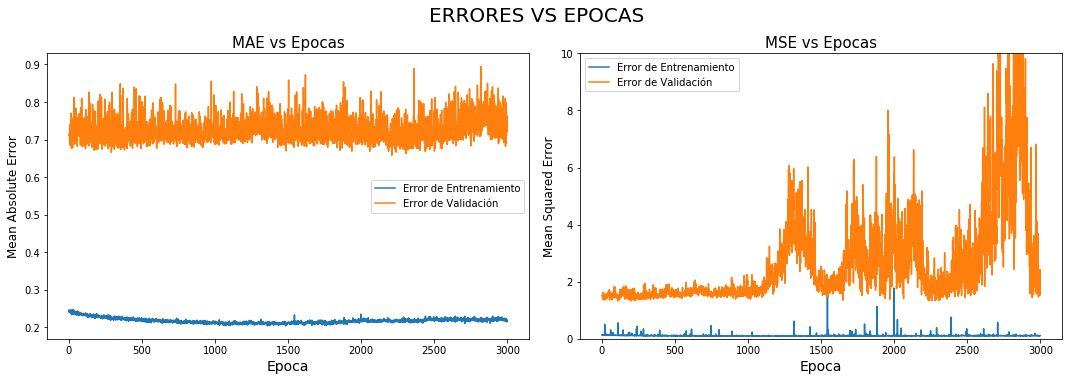

In [40]:
#Graficando MAE & MSE vs épocas
plot_history(history)

In [41]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.71
Mean Square Error, del conjunto de Test:  1.38


In [42]:
# Generando las predicciones
y_predict = model.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[-0.05362082  0.67783785]
 [ 1.1579907   0.69148916]
 [ 0.34520975  0.7393684 ]
 [-0.64030635  1.8032846 ]
 [-1.1224335   1.8207806 ]]
Valores Reales
[[-0.01410099  0.43851354]
 [ 0.90625105  0.74593764]
 [ 0.81327691  0.33611374]
 [-0.70962814  1.61685259]
 [-0.55983427  1.07146232]]


In [43]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.062860,0.358083
MSE,2.527292,0.235089
RMSE,1.589746,0.484860
MAPE,333.056216,49.698586
MAXE,9.341840,2.344885


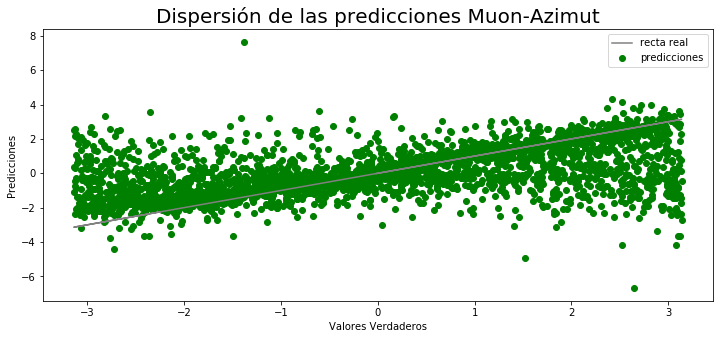

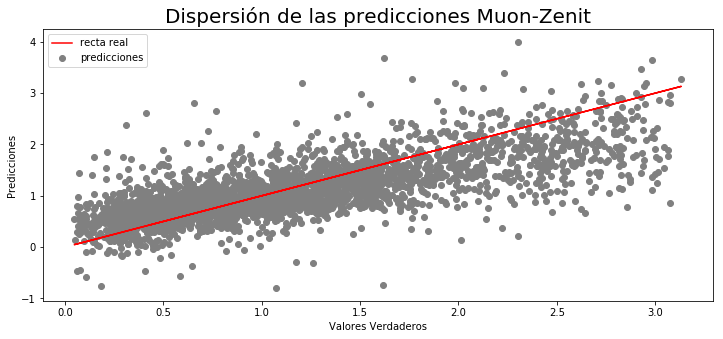

In [44]:
#Graficando las dispersiones
graf_disp()

## MODELADO CON "PODA" Y SELECCIÓN DE FEATURES.

<font size=4> Una vez llegado a este punto se observa que no por aumentar las epocas mejoran las métricas del modelo, por lo que se utilizará un acercamiento diferente al problema.
    
Hasta el momento se ha optado por utilizar todas las columnas (features) del dataset, sin embargo aquí "escogeremos" sólo las que pensamos son más relevantes, haciendo un análisis práctico llamado feature selection.

Se utilizará un mapa de calor como criterio para discriminar aquellas variables predictoras que sean "menos relevantes".
</font>

In [51]:
#Columnas independientes previamente almacenadas en el dataframe X (variables predictoras)
X.sample(3)

,lin_det,piso_det,mód_opt,X',Y',Z',azimut,zenit,tiempo,t_selp,amp,frec_hits,aafit_azimut,aafit_zenit,aafit_lambda,aafit_beta,bbfit_azimut,bbfit_zenit,bbfit_quality
18664932,7,3,1,-35.893514,-14.819340,-141.629434,1.431530,2.356193,641.935667,88.216784,0.164491,123.844147,-1.373628,0.518521,-5.263123,0.007922,-1.424077,0.539505,1.193205
43380631,9,15,2,-94.766113,9.035013,32.084566,2.498276,2.356193,-1422.949584,206.888443,1.219768,75.912476,0.974980,0.951274,-6.455412,0.017676,-9.424778,1.085790,1.979812
32611060,4,20,1,44.484704,9.859334,104.564566,2.552615,2.356193,2287.482336,1126.855901,0.423364,76.808929,-1.674259,1.081991,-5.496164,0.011077,-9.424778,1.206756,2.004184


In [53]:
#Columnas dependientes previamente seleccionadas en el dataframe Y
Y.sample(3)

,muon_azimut,muon_zenit
30550212,-1.224354,0.377204
55093248,-2.060083,1.008342
44848653,-1.048494,0.329834


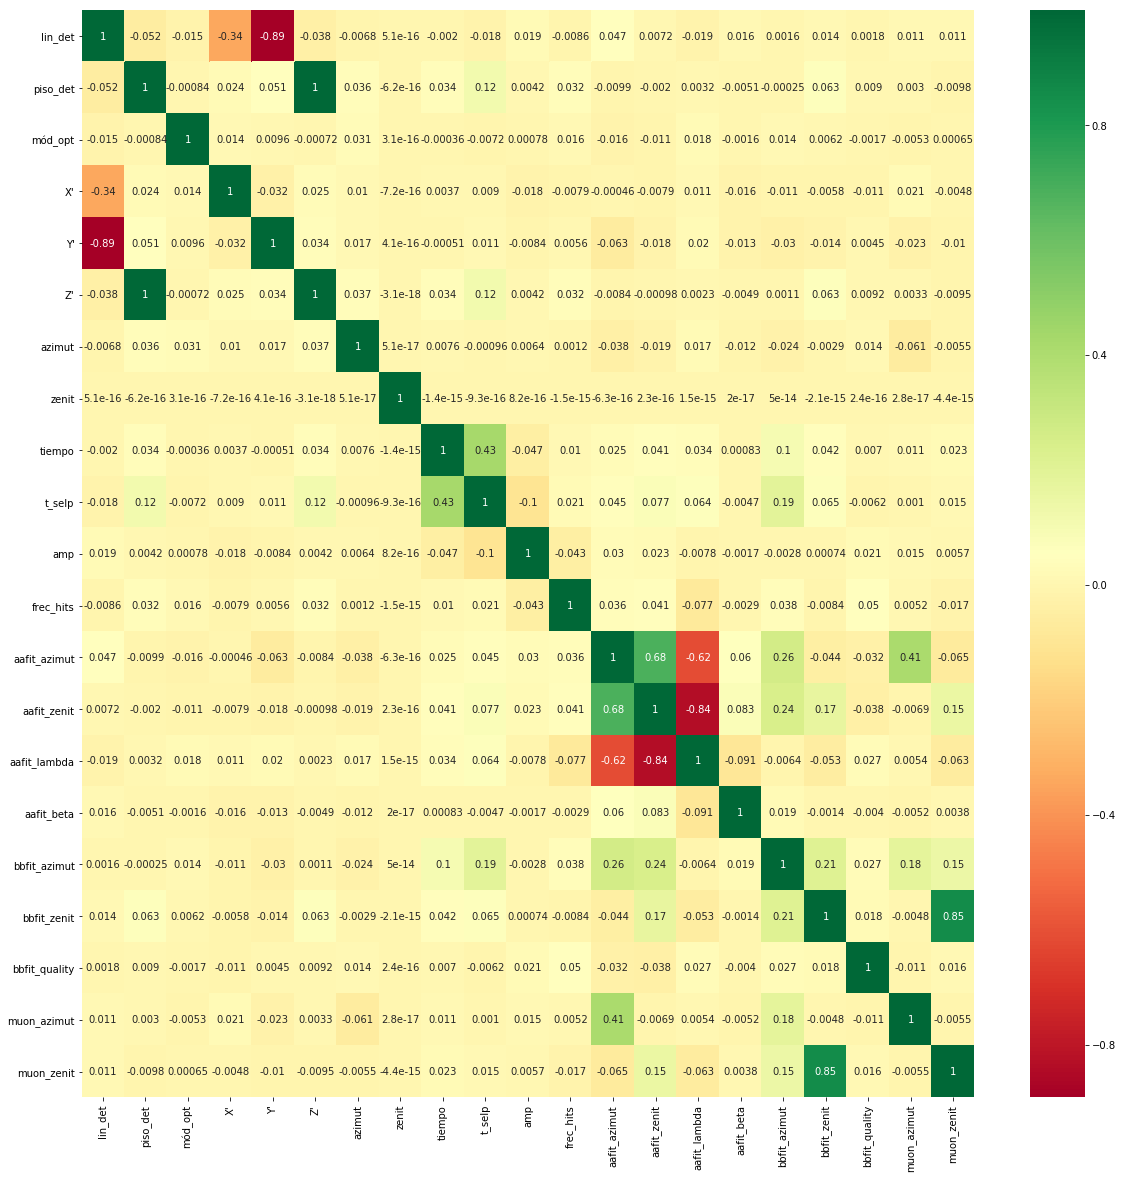

In [59]:
#Generamos un  - Mapa de calor -
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [96]:
#Correlación con muon_azimut y muon_zenit
cor_maz = abs(corrmat["muon_azimut"])
cor_mze = abs(corrmat["muon_zenit"])

#Seleccionando las "más relevantes"
rel_feat_cor_maz = cor_maz[cor_maz>0.01]
rel_feat_cor_mze = cor_maz[cor_maz>0.01]

print(rel_feat_cor_maz)
print()
print(rel_feat_cor_mze)

lin_det          0.011237
X'               0.021343
Y'               0.023184
azimut           0.060782
tiempo           0.010542
amp              0.014654
aafit_azimut     0.414032
bbfit_azimut     0.180318
bbfit_quality    0.010530
muon_azimut      1.000000
Name: muon_azimut, dtype: float64

lin_det          0.011237
X'               0.021343
Y'               0.023184
azimut           0.060782
tiempo           0.010542
amp              0.014654
aafit_azimut     0.414032
bbfit_azimut     0.180318
bbfit_quality    0.010530
muon_azimut      1.000000
Name: muon_azimut, dtype: float64


### Análisis del mapa de calor y de la correlación

Como se puede observar, si tomamos como primer criterio las que por su naturaleza sabemos que están realmente relacionadas escogemos primero las siguientes:

aafit (todas)
bbfit (todas)

Tomando como siguiente criterio aquellas cuyo valor absoluto sea mayor a 0.01, nos quedaremos entonces con:
aafit (todas)
bbfit (todas)
lin_det
X'
Y'
azimut
tiempo
amp

Por lo tanto reduciremos el número de "features" (columnas) a únicamente 13.

Finalmente el conjunto queda como sigue:

['lin_det', 'X'', 'Y'', 'azimut','tiempo','amp', 'aafit_azimut', 'aafit_zenit','aafit_lambda', 'aafit_beta','bbfit_azimut', 'bbfit_zenit','bbfit_quality']


In [113]:
#Generamos un nuevo dataframe conteniendo únicamente las columnas que seleccionamos
dataset_recortado = dataset[['lin_det','X\'','Y\'','azimut','tiempo','amp','aafit_azimut','aafit_zenit','aafit_lambda',
                             'aafit_beta','bbfit_azimut','bbfit_zenit','bbfit_quality','muon_azimut','muon_zenit']]

In [114]:
dataset_recortado.sample(5)

,lin_det,X',Y',azimut,tiempo,amp,aafit_azimut,aafit_zenit,aafit_lambda,aafit_beta,bbfit_azimut,bbfit_zenit,bbfit_quality,muon_azimut,muon_zenit
55988383,7,-36.094693,-15.956836,-1.781740,408.365287,0.745564,-2.269803,2.993521,-6.804401,0.011721,2.043886,1.561573,3.444095,1.893182,2.823721
46726682,3,-10.283274,37.110256,-2.135990,111.346586,8.662042,-0.771958,0.577647,-5.812830,0.012813,-9.424778,1.159866,1.766743,-0.812223,1.208217
61667539,9,-93.772278,8.915460,0.403879,125.690837,3.110073,-0.952377,1.779938,-6.526656,0.085715,-9.424778,0.386224,1.347133,-0.289514,1.187353
25539664,6,92.572397,-22.531797,-0.466870,433.537796,3.654462,-0.045824,0.205475,-4.637612,0.009631,-9.424778,0.195174,0.570928,-0.356126,0.243430
12941660,5,-58.080022,77.673618,-1.018766,147.568153,8.120070,-1.602096,1.541956,-6.055787,0.010596,-1.763112,1.593567,8.717810,-1.949069,2.629528


In [124]:
### DIVISION DE LA DATA EN TRAIN Y TEST PARA VALIDACIÓN HOLD-OUT INICIAL (VALIDACIÓN ANIDADA AL FINAL)
X_rec = dataset_recortado.iloc[:,:13]; Y_rec = dataset_recortado.iloc[:,13:15]

X_train, X_test, Y_train, Y_test = train_test_split(X_rec, Y_rec, test_size=0.3, random_state=rs)

train_dataset = X_train
test_dataset = X_test
train_labels = Y_train
test_labels = Y_test

In [125]:
#Construyendo el modelo nuevamente
model_rec = build_model()

In [126]:
#Viendo el resumen (capas y parámetros) del modelo
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               10240     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 1,061,378
Trainable params: 1,061,378
Non-trainable params: 0
_________________________________________________________________


In [127]:
#Probando si la salida del modelo es del "shape" esperado
example_batch = train_dataset[:5]
result = model_rec.predict(example_batch)

In [128]:
#Viendo el "batch" de ejemplo
example_batch

,lin_det,X',Y',azimut,tiempo,amp,aafit_azimut,aafit_zenit,aafit_lambda,aafit_beta,bbfit_azimut,bbfit_zenit,bbfit_quality
41247649,6,91.537303,-22.017381,2.685905,137.877396,7.419613,-1.545984,0.545157,-6.060319,0.005439,-1.653827,0.688542,1.844221
38269624,3,-9.921345,38.173874,1.480009,128.930750,3.267774,-9.424778,-9.424778,1.000000,-1.000000,-9.424778,1.228090,3.341144
54617978,12,-15.448988,-94.107800,3.065515,-154.648910,0.821330,-0.000343,0.593653,-6.440619,0.020818,-9.424778,0.932633,3.465858
36860860,2,75.855418,57.763479,2.585370,768.011906,5.698338,-2.305746,0.943282,-4.788101,0.006816,-2.181483,0.955478,1.054585
52854785,11,-79.141422,-58.487262,-2.456855,650.729326,2.309163,0.573282,1.146408,-5.516725,0.007052,0.631700,1.144783,1.190997


In [129]:
#"Observando" la "forma" de la salida del modelo prediciendo (aun sin entrenar)
#solo queremos verificar que la "forma" de salida sea la correcta
result

array([[  4.8079867,  -7.050707 ],
       [  2.1744323,  -7.8553247],
       [  0.2656741,  -9.555251 ],
       [ 13.29035  , -39.069904 ],
       [  5.908987 , -38.683083 ]], dtype=float32)

In [131]:
# Realizando el proceso de entrenamiento e imprimiendo un punto por cada epoca usando "callbacks"
EPOCHS = 100
#Entrenamos el modelo, el verbose se puede cambiar a uno si lo deseamos para visualizar mas a detalle el proceso
history = model_rec.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split = 0.3, verbose=1, callbacks=[PrintDot()])

Train on 4900 samples, validate on 2100 samples
Epoch 1/100
4900/4900 [==============================] - 1s 199us/sample - loss: 4907.2445 - mean_absolute_error: 11.9633 - mean_squared_error: 4907.2476 - val_loss: 53.8156 - val_mean_absolute_error: 2.3542 - val_mean_squared_error: 53.8156
Epoch 2/100
4900/4900 [==============================] - 1s 153us/sample - loss: 173.7919 - mean_absolute_error: 2.1667 - mean_squared_error: 173.7919 - val_loss: 4.5103 - val_mean_absolute_error: 1.4589 - val_mean_squared_error: 4.5103
Epoch 3/100
4900/4900 [==============================] - 1s 152us/sample - loss: 8.8412 - mean_absolute_error: 1.4192 - mean_squared_error: 8.8412 - val_loss: 2.5644 - val_mean_absolute_error: 1.1997 - val_mean_squared_error: 2.5644
Epoch 4/100
4900/4900 [==============================] - 1s 148us/sample - loss: 7.3726 - mean_absolute_error: 1.2711 - mean_squared_error: 7.3726 - val_loss: 2.6042 - val_mean_absolute_error: 1.2252 - val_mean_squared_error: 2.6042
Epoch 5

4900/4900 [==============================] - 1s 146us/sample - loss: 0.8943 - mean_absolute_error: 0.5827 - mean_squared_error: 0.8943 - val_loss: 1.1448 - val_mean_absolute_error: 0.6643 - val_mean_squared_error: 1.1448
Epoch 71/100
4900/4900 [==============================] - 1s 152us/sample - loss: 0.8880 - mean_absolute_error: 0.5856 - mean_squared_error: 0.8880 - val_loss: 1.1574 - val_mean_absolute_error: 0.6533 - val_mean_squared_error: 1.1574
Epoch 72/100
4900/4900 [==============================] - 1s 162us/sample - loss: 0.8823 - mean_absolute_error: 0.5827 - mean_squared_error: 0.8823 - val_loss: 1.3901 - val_mean_absolute_error: 0.7808 - val_mean_squared_error: 1.3901
Epoch 73/100
4900/4900 [==============================] - 1s 148us/sample - loss: 0.9270 - mean_absolute_error: 0.5869 - mean_squared_error: 0.9270 - val_loss: 1.4170 - val_mean_absolute_error: 0.7981 - val_mean_squared_error: 1.4170
Epoch 74/100
4900/4900 [==============================] - 1s 153us/sample - l

In [132]:
#Guardamos el modelo ya entrenado y sus resultados en un DataFrama para análisis posterior
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,0.820185,0.548746,0.820185,1.351678,0.762372,1.351678,95
96,0.791860,0.552515,0.791860,1.207545,0.653219,1.207545,96
97,0.789729,0.551888,0.789729,1.285426,0.715571,1.285426,97
98,0.769417,0.544729,0.769417,1.197130,0.671192,1.197130,98
99,0.774076,0.545651,0.774076,1.523793,0.854961,1.523793,99


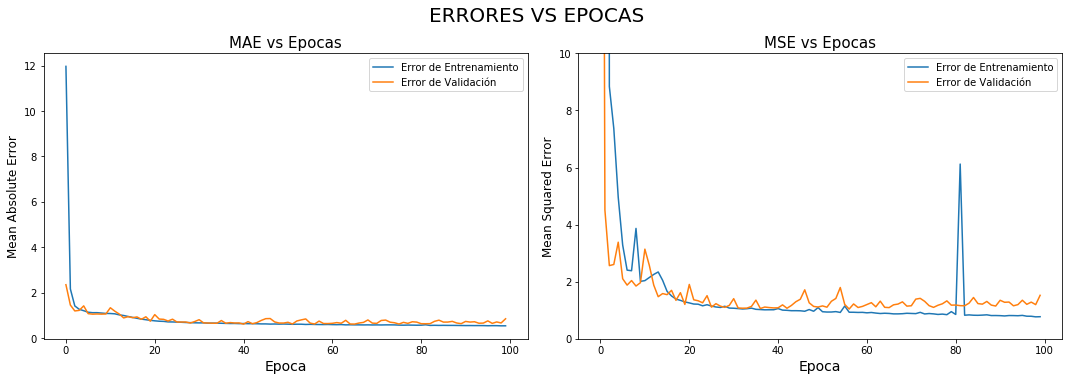

In [133]:
#Graficando MAE & MSE vs épocas
plot_history(history)

In [135]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model_rec.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.85
Mean Square Error, del conjunto de Test:  1.54


In [136]:
# Generando las predicciones
y_predict = model_rec.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[ 0.22275987  0.6006384 ]
 [-0.9503765   1.5037637 ]
 [-1.7909142   2.2297242 ]
 [ 0.16494206  1.9017069 ]
 [-3.339333    2.1741414 ]]
Valores Reales
[[ 0.23624189  0.36066225]
 [-0.30033259  0.84725319]
 [-0.46081619  2.56209755]
 [ 0.98577492  1.9117797 ]
 [-1.90603035  1.40997404]]


In [137]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.232737,0.472833
MSE,2.759407,0.328145
RMSE,1.661146,0.572839
MAPE,318.786688,70.167246
MAXE,15.797118,2.572612


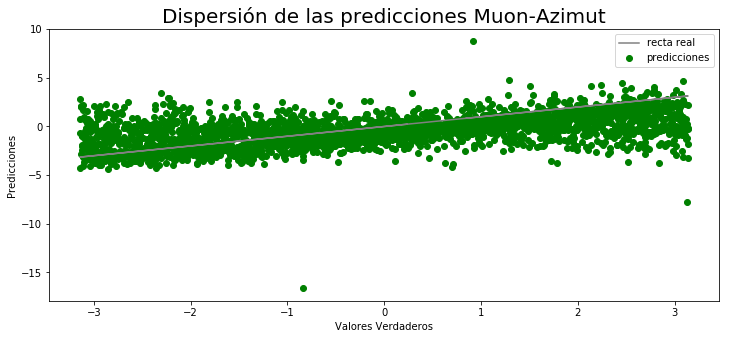

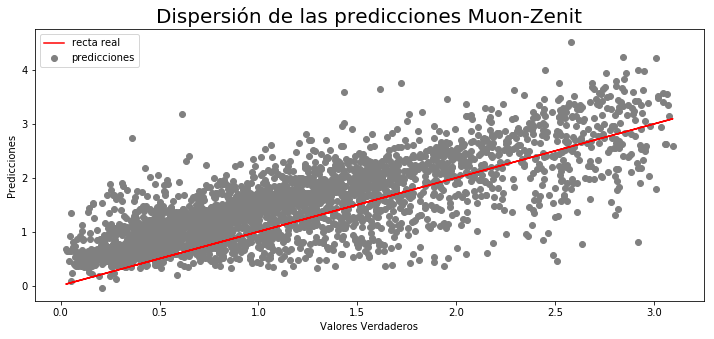

In [138]:
#Graficando las dispersiones
graf_disp()

## Entrenando el modelo recortado por 500 épocas

In [143]:
# Realizando el proceso de entrenamiento e imprimiendo un punto por cada epoca usando "callbacks"
EPOCHS = 500
#Entrenamos el modelo, el verbose se puede cambiar a uno si lo deseamos para visualizar mas a detalle el proceso
history = model_rec.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split = 0.3, verbose=1, callbacks=[PrintDot()])

Train on 4900 samples, validate on 2100 samples
Epoch 1/500
4900/4900 [==============================] - 1s 142us/sample - loss: 0.5804 - mean_absolute_error: 0.4706 - mean_squared_error: 0.5804 - val_loss: 1.4485 - val_mean_absolute_error: 0.7525 - val_mean_squared_error: 1.4485
Epoch 2/500
4900/4900 [==============================] - 1s 152us/sample - loss: 0.5760 - mean_absolute_error: 0.4724 - mean_squared_error: 0.5760 - val_loss: 1.3550 - val_mean_absolute_error: 0.6898 - val_mean_squared_error: 1.3550
Epoch 3/500
4900/4900 [==============================] - 1s 160us/sample - loss: 0.5776 - mean_absolute_error: 0.4655 - mean_squared_error: 0.5776 - val_loss: 1.4597 - val_mean_absolute_error: 0.8030 - val_mean_squared_error: 1.4597
Epoch 4/500
4900/4900 [==============================] - 1s 154us/sample - loss: 0.6074 - mean_absolute_error: 0.4672 - mean_squared_error: 0.6074 - val_loss: 1.3989 - val_mean_absolute_error: 0.6832 - val_mean_squared_error: 1.3989
Epoch 5/500
4900/490

4900/4900 [==============================] - 1s 152us/sample - loss: 0.4875 - mean_absolute_error: 0.4337 - mean_squared_error: 0.4875 - val_loss: 1.3570 - val_mean_absolute_error: 0.7297 - val_mean_squared_error: 1.3570
Epoch 71/500
4900/4900 [==============================] - 1s 160us/sample - loss: 0.4870 - mean_absolute_error: 0.4345 - mean_squared_error: 0.4870 - val_loss: 1.3075 - val_mean_absolute_error: 0.6765 - val_mean_squared_error: 1.3075
Epoch 72/500
4900/4900 [==============================] - 1s 163us/sample - loss: 0.4864 - mean_absolute_error: 0.4316 - mean_squared_error: 0.4864 - val_loss: 1.3764 - val_mean_absolute_error: 0.7003 - val_mean_squared_error: 1.3764
Epoch 73/500
4900/4900 [==============================] - 1s 165us/sample - loss: 0.4728 - mean_absolute_error: 0.4264 - mean_squared_error: 0.4728 - val_loss: 1.4505 - val_mean_absolute_error: 0.7972 - val_mean_squared_error: 1.4505
Epoch 74/500
4900/4900 [==============================] - 1s 173us/sample - l

4900/4900 [==============================] - 1s 172us/sample - loss: 0.4169 - mean_absolute_error: 0.4034 - mean_squared_error: 0.4169 - val_loss: 1.4325 - val_mean_absolute_error: 0.7303 - val_mean_squared_error: 1.4325
Epoch 139/500
4900/4900 [==============================] - 1s 171us/sample - loss: 0.4317 - mean_absolute_error: 0.4109 - mean_squared_error: 0.4317 - val_loss: 1.3843 - val_mean_absolute_error: 0.7370 - val_mean_squared_error: 1.3843
Epoch 140/500
4900/4900 [==============================] - 1s 166us/sample - loss: 0.4023 - mean_absolute_error: 0.4002 - mean_squared_error: 0.4023 - val_loss: 1.6586 - val_mean_absolute_error: 0.8136 - val_mean_squared_error: 1.6586
Epoch 141/500
4900/4900 [==============================] - 1s 161us/sample - loss: 0.4123 - mean_absolute_error: 0.4021 - mean_squared_error: 0.4123 - val_loss: 1.4141 - val_mean_absolute_error: 0.7223 - val_mean_squared_error: 1.4141
Epoch 142/500
4900/4900 [==============================] - 1s 168us/sample

Epoch 173/500
4900/4900 [==============================] - 1s 177us/sample - loss: 0.3874 - mean_absolute_error: 0.3920 - mean_squared_error: 0.3874 - val_loss: 1.4432 - val_mean_absolute_error: 0.7404 - val_mean_squared_error: 1.4432
Epoch 174/500
4900/4900 [==============================] - 1s 191us/sample - loss: 0.3851 - mean_absolute_error: 0.3948 - mean_squared_error: 0.3851 - val_loss: 1.4197 - val_mean_absolute_error: 0.7527 - val_mean_squared_error: 1.4197
Epoch 175/500
4900/4900 [==============================] - 1s 193us/sample - loss: 0.3965 - mean_absolute_error: 0.3957 - mean_squared_error: 0.3965 - val_loss: 1.4582 - val_mean_absolute_error: 0.7518 - val_mean_squared_error: 1.4582
Epoch 176/500
4900/4900 [==============================] - 1s 168us/sample - loss: 0.3970 - mean_absolute_error: 0.3934 - mean_squared_error: 0.3970 - val_loss: 1.5282 - val_mean_absolute_error: 0.7215 - val_mean_squared_error: 1.5282
Epoch 177/500
4900/4900 [==============================] - 1

Epoch 242/500
4900/4900 [==============================] - 1s 144us/sample - loss: 0.3645 - mean_absolute_error: 0.3777 - mean_squared_error: 0.3645 - val_loss: 1.4173 - val_mean_absolute_error: 0.7070 - val_mean_squared_error: 1.4173
Epoch 243/500
4900/4900 [==============================] - 1s 151us/sample - loss: 0.3566 - mean_absolute_error: 0.3792 - mean_squared_error: 0.3566 - val_loss: 1.4489 - val_mean_absolute_error: 0.7458 - val_mean_squared_error: 1.4489
Epoch 244/500
4900/4900 [==============================] - 1s 150us/sample - loss: 0.3604 - mean_absolute_error: 0.3782 - mean_squared_error: 0.3604 - val_loss: 1.3986 - val_mean_absolute_error: 0.7127 - val_mean_squared_error: 1.3986
Epoch 245/500
4900/4900 [==============================] - 1s 137us/sample - loss: 0.3471 - mean_absolute_error: 0.3701 - mean_squared_error: 0.3471 - val_loss: 1.6836 - val_mean_absolute_error: 0.8590 - val_mean_squared_error: 1.6836
Epoch 246/500
4900/4900 [==============================] - 1

Epoch 277/500
4900/4900 [==============================] - 1s 236us/sample - loss: 0.3354 - mean_absolute_error: 0.3695 - mean_squared_error: 0.3354 - val_loss: 1.4822 - val_mean_absolute_error: 0.7757 - val_mean_squared_error: 1.4822
Epoch 278/500
4900/4900 [==============================] - 1s 164us/sample - loss: 0.4141 - mean_absolute_error: 0.3797 - mean_squared_error: 0.4141 - val_loss: 1.4804 - val_mean_absolute_error: 0.7236 - val_mean_squared_error: 1.4804
Epoch 279/500
4900/4900 [==============================] - 1s 158us/sample - loss: 0.3624 - mean_absolute_error: 0.3763 - mean_squared_error: 0.3624 - val_loss: 1.4160 - val_mean_absolute_error: 0.7218 - val_mean_squared_error: 1.4160
Epoch 280/500
4900/4900 [==============================] - 1s 148us/sample - loss: 0.3531 - mean_absolute_error: 0.3777 - mean_squared_error: 0.3531 - val_loss: 1.4190 - val_mean_absolute_error: 0.6943 - val_mean_squared_error: 1.4190
Epoch 281/500
4900/4900 [==============================] - 1

Epoch 346/500
4900/4900 [==============================] - 1s 142us/sample - loss: 0.3116 - mean_absolute_error: 0.3546 - mean_squared_error: 0.3116 - val_loss: 1.6677 - val_mean_absolute_error: 0.8205 - val_mean_squared_error: 1.6677
Epoch 347/500
4900/4900 [==============================] - 1s 154us/sample - loss: 0.3290 - mean_absolute_error: 0.3622 - mean_squared_error: 0.3290 - val_loss: 1.5353 - val_mean_absolute_error: 0.8082 - val_mean_squared_error: 1.5353
Epoch 348/500
4900/4900 [==============================] - 1s 161us/sample - loss: 0.3170 - mean_absolute_error: 0.3604 - mean_squared_error: 0.3170 - val_loss: 1.5561 - val_mean_absolute_error: 0.7926 - val_mean_squared_error: 1.5561
Epoch 349/500
4900/4900 [==============================] - 1s 145us/sample - loss: 0.3171 - mean_absolute_error: 0.3580 - mean_squared_error: 0.3171 - val_loss: 1.5363 - val_mean_absolute_error: 0.7761 - val_mean_squared_error: 1.5363
Epoch 350/500
4900/4900 [==============================] - 1

Epoch 381/500
4900/4900 [==============================] - 1s 150us/sample - loss: 0.2976 - mean_absolute_error: 0.3516 - mean_squared_error: 0.2976 - val_loss: 1.4706 - val_mean_absolute_error: 0.7456 - val_mean_squared_error: 1.4706
Epoch 382/500
4900/4900 [==============================] - 1s 161us/sample - loss: 0.3066 - mean_absolute_error: 0.3551 - mean_squared_error: 0.3066 - val_loss: 1.4440 - val_mean_absolute_error: 0.7853 - val_mean_squared_error: 1.4440
Epoch 383/500
4900/4900 [==============================] - 1s 165us/sample - loss: 0.3259 - mean_absolute_error: 0.3487 - mean_squared_error: 0.3259 - val_loss: 1.5560 - val_mean_absolute_error: 0.7934 - val_mean_squared_error: 1.5560
Epoch 384/500
4900/4900 [==============================] - 1s 155us/sample - loss: 0.3033 - mean_absolute_error: 0.3499 - mean_squared_error: 0.3033 - val_loss: 1.6094 - val_mean_absolute_error: 0.8112 - val_mean_squared_error: 1.6094
Epoch 385/500
4900/4900 [==============================] - 1

Epoch 450/500
4900/4900 [==============================] - 1s 164us/sample - loss: 0.2831 - mean_absolute_error: 0.3428 - mean_squared_error: 0.2831 - val_loss: 1.4310 - val_mean_absolute_error: 0.7344 - val_mean_squared_error: 1.4310
Epoch 451/500
4900/4900 [==============================] - 1s 157us/sample - loss: 0.2857 - mean_absolute_error: 0.3428 - mean_squared_error: 0.2857 - val_loss: 1.6267 - val_mean_absolute_error: 0.7928 - val_mean_squared_error: 1.6267
Epoch 452/500
4900/4900 [==============================] - 1s 178us/sample - loss: 0.2911 - mean_absolute_error: 0.3451 - mean_squared_error: 0.2911 - val_loss: 1.4616 - val_mean_absolute_error: 0.7305 - val_mean_squared_error: 1.4616
Epoch 453/500
4900/4900 [==============================] - 1s 165us/sample - loss: 0.2761 - mean_absolute_error: 0.3367 - mean_squared_error: 0.2761 - val_loss: 1.6000 - val_mean_absolute_error: 0.7786 - val_mean_squared_error: 1.6000
Epoch 454/500
4900/4900 [==============================] - 1

Epoch 485/500
4900/4900 [==============================] - 1s 179us/sample - loss: 0.2691 - mean_absolute_error: 0.3357 - mean_squared_error: 0.2691 - val_loss: 1.5420 - val_mean_absolute_error: 0.7918 - val_mean_squared_error: 1.5420
Epoch 486/500
4900/4900 [==============================] - 1s 176us/sample - loss: 0.2552 - mean_absolute_error: 0.3304 - mean_squared_error: 0.2552 - val_loss: 1.5353 - val_mean_absolute_error: 0.8077 - val_mean_squared_error: 1.5353
Epoch 487/500
4900/4900 [==============================] - 1s 163us/sample - loss: 0.2804 - mean_absolute_error: 0.3381 - mean_squared_error: 0.2804 - val_loss: 1.4210 - val_mean_absolute_error: 0.7180 - val_mean_squared_error: 1.4210
Epoch 488/500
4900/4900 [==============================] - 1s 160us/sample - loss: 0.2744 - mean_absolute_error: 0.3365 - mean_squared_error: 0.2744 - val_loss: 1.4876 - val_mean_absolute_error: 0.7565 - val_mean_squared_error: 1.4876
Epoch 489/500
4900/4900 [==============================] - 1

In [144]:
#Guardamos el modelo ya entrenado y sus resultados en un DataFrama para análisis posterior
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
495,0.264993,0.333723,0.264993,1.733741,0.798037,1.733741,495
496,0.294919,0.340850,0.294919,1.433479,0.758497,1.433479,496
497,0.258562,0.331231,0.258562,1.467497,0.750874,1.467497,497
498,0.275477,0.339920,0.275477,1.504963,0.723969,1.504963,498
499,0.272624,0.333419,0.272624,1.557381,0.790142,1.557380,499


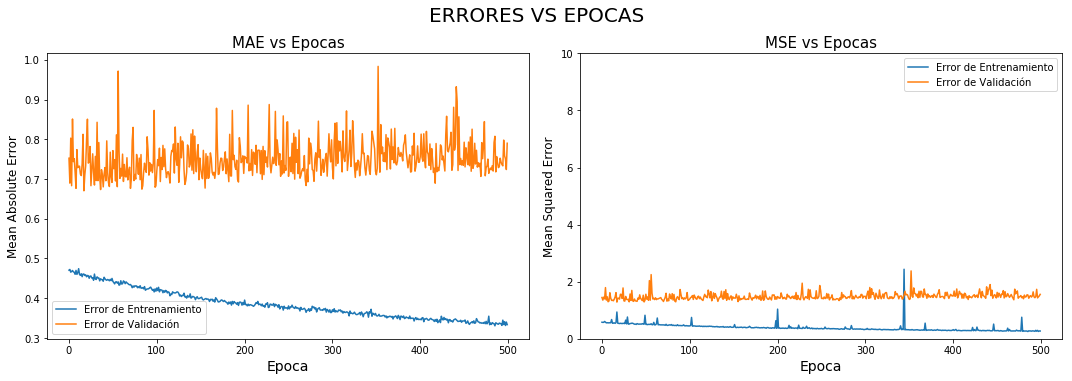

In [145]:
#Graficando MAE & MSE vs épocas
plot_history(history)

In [146]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model_rec.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.82
Mean Square Error, del conjunto de Test:  1.77


In [147]:
# Generando las predicciones
y_predict = model_rec.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[ 2.2727637   0.8813478 ]
 [-0.25050715  1.0643134 ]
 [-0.14197692  1.4690831 ]
 [ 0.9585819   1.7969624 ]
 [-0.93022704  1.2380304 ]]
Valores Reales
[[ 0.23624189  0.36066225]
 [-0.30033259  0.84725319]
 [-0.46081619  2.56209755]
 [ 0.98577492  1.9117797 ]
 [-1.90603035  1.40997404]]


In [148]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.273308,0.358918
MSE,3.197486,0.341539
RMSE,1.788151,0.584413
MAPE,591.633773,49.482407
MAXE,26.988263,17.583060


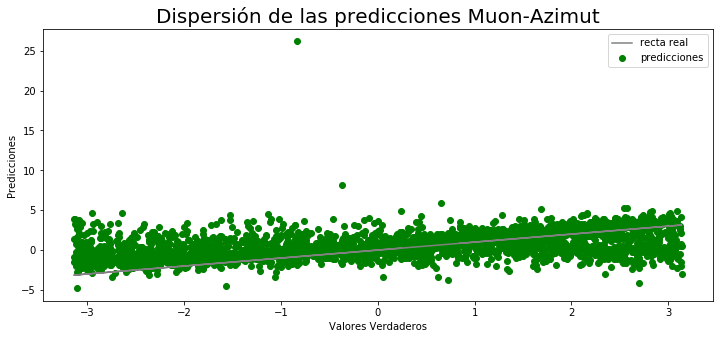

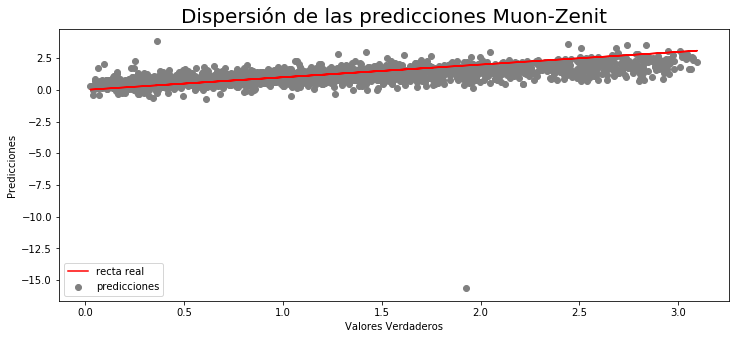

In [149]:
#Graficando las dispersiones
graf_disp()

## Modelado Recortado utilizando "early-stop"


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

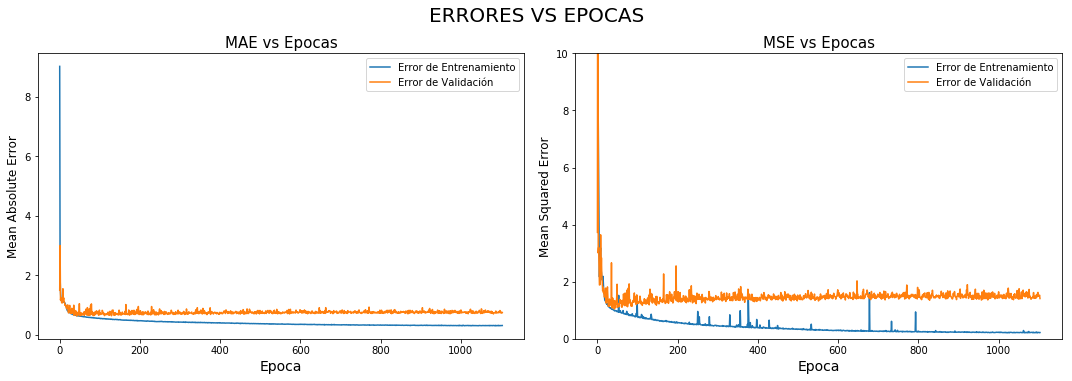

In [172]:
#Volviendo a re-entrenar el modelo pero ahora, para detenerlo en caso de que no mejore el score de validación.
#Se utilizará una llamada de "Parada Temprana".
#Tomado de la referencia de keras de regresión básica

EPOCHS = 10000
model_early_stop = build_model()

#El parámetro patience es el número de épocas que esperaremos para una mejora
early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)

history = model_early_stop.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.3, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [173]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model_early_stop.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.74
Mean Square Error, del conjunto de Test:  1.70


In [174]:
# Generando las predicciones
y_predict = model_early_stop.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[ 0.72738516  0.66790926]
 [-0.85478497  0.614537  ]
 [-0.12629992  1.5055571 ]
 [ 0.76955616  1.5167649 ]
 [-1.3080518   1.536304  ]]
Valores Reales
[[ 0.23624189  0.36066225]
 [-0.30033259  0.84725319]
 [-0.46081619  2.56209755]
 [ 0.98577492  1.9117797 ]
 [-1.90603035  1.40997404]]


In [175]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.118944,0.356749
MSE,3.035953,0.361426
RMSE,1.742399,0.601187
MAPE,293.057565,48.586830
MAXE,38.049430,19.753001


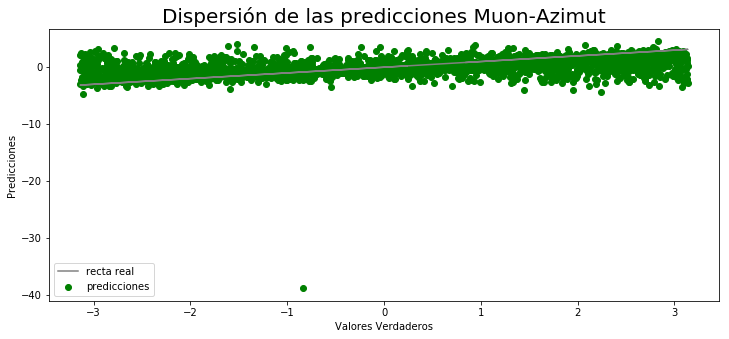

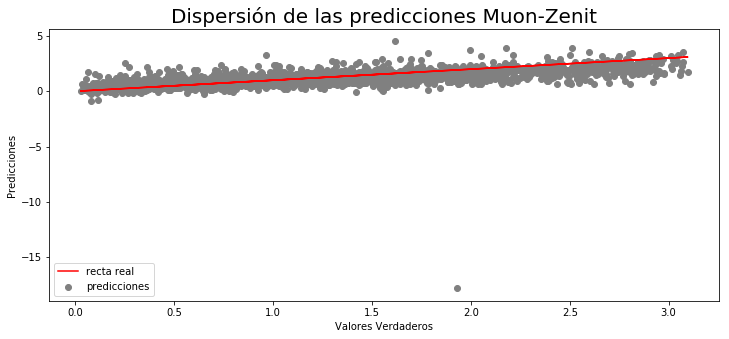

In [176]:
#Graficando las dispersiones
graf_disp()

# PRUEBA CON UN MODELO DE MAYOR NÚMERO DE NODOS Y CAPAS Y VARIANDO EL LEARNING RATE


In [206]:
#Probando con otro tipo de modelo para tratar de mejorar la salida y minimizar el error

def build_model_2(lr):
    model = keras.Sequential([
        #Capa inicial, incluye la forma de la entrada
        layers.Dense(512, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        #Capas "ocultas"
        layers.Dense(1024, activation=tf.nn.relu),
        layers.Dense(1024, activation=tf.nn.relu),
        layers.Dense(1024, activation=tf.nn.relu),
        layers.Dense(1024, activation=tf.nn.relu),
        layers.Dense(512, activation=tf.nn.relu),
        #Capa de salida
        layers.Dense(2)
    ])
    opt = tf.keras.optimizers.RMSprop(lr) #Revisar si hay que aumentarlo o disminuirlo!!!, ¿menor o mayor learning rate?
    model.compile(loss='mean_squared_error', optimizer = opt, metrics=['mean_absolute_error','mean_squared_error'])
    return model

In [197]:
lr = 0.0001
model2 = build_model_2(lr)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 512)               7168      
_________________________________________________________________
dense_82 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_83 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_84 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_85 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_86 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_87 (Dense)             (None, 2)                 1026      
Total para

Train on 4900 samples, validate on 2100 samples
Epoch 1/500
4900/4900 [==============================] - 1s 281us/sample - loss: 107.5072 - mean_absolute_error: 3.4562 - mean_squared_error: 107.5072 - val_loss: 22.7984 - val_mean_absolute_error: 2.9678 - val_mean_squared_error: 22.7984
Epoch 2/500
4900/4900 [==============================] - 1s 188us/sample - loss: 5.7003 - mean_absolute_error: 1.5434 - mean_squared_error: 5.7003 - val_loss: 4.1231 - val_mean_absolute_error: 1.4069 - val_mean_squared_error: 4.1231
Epoch 3/500
4900/4900 [==============================] - ETA: 0s - loss: 3.8802 - mean_absolute_error: 1.2572 - mean_squared_error: 3.880 - 1s 187us/sample - loss: 3.7788 - mean_absolute_error: 1.2515 - mean_squared_error: 3.7788 - val_loss: 2.8391 - val_mean_absolute_error: 1.3004 - val_mean_squared_error: 2.8391
Epoch 4/500
4900/4900 [==============================] - 1s 186us/sample - loss: 3.3798 - mean_absolute_error: 1.1891 - mean_squared_error: 3.3798 - val_loss: 2.241

Epoch 35/500
4900/4900 [==============================] - 1s 187us/sample - loss: 1.4857 - mean_absolute_error: 0.8928 - mean_squared_error: 1.4857 - val_loss: 1.6001 - val_mean_absolute_error: 0.9299 - val_mean_squared_error: 1.6001
Epoch 36/500
4900/4900 [==============================] - 1s 197us/sample - loss: 1.4717 - mean_absolute_error: 0.8840 - mean_squared_error: 1.4717 - val_loss: 1.4479 - val_mean_absolute_error: 0.8482 - val_mean_squared_error: 1.4479
Epoch 37/500
4900/4900 [==============================] - 1s 194us/sample - loss: 1.4615 - mean_absolute_error: 0.8765 - mean_squared_error: 1.4615 - val_loss: 1.5983 - val_mean_absolute_error: 0.9472 - val_mean_squared_error: 1.5983
Epoch 38/500
4900/4900 [==============================] - 1s 196us/sample - loss: 1.4286 - mean_absolute_error: 0.8614 - mean_squared_error: 1.4286 - val_loss: 2.1199 - val_mean_absolute_error: 1.1226 - val_mean_squared_error: 2.1199
Epoch 39/500
4900/4900 [==============================] - 1s 200

4900/4900 [==============================] - 1s 190us/sample - loss: 0.9061 - mean_absolute_error: 0.6197 - mean_squared_error: 0.9061 - val_loss: 1.4896 - val_mean_absolute_error: 0.8218 - val_mean_squared_error: 1.4896
Epoch 105/500
4900/4900 [==============================] - 1s 187us/sample - loss: 0.9185 - mean_absolute_error: 0.6227 - mean_squared_error: 0.9185 - val_loss: 1.5334 - val_mean_absolute_error: 0.7869 - val_mean_squared_error: 1.5334
Epoch 106/500
4900/4900 [==============================] - 1s 192us/sample - loss: 0.9152 - mean_absolute_error: 0.6220 - mean_squared_error: 0.9152 - val_loss: 1.2054 - val_mean_absolute_error: 0.7118 - val_mean_squared_error: 1.2054
Epoch 107/500
4900/4900 [==============================] - 1s 204us/sample - loss: 0.9129 - mean_absolute_error: 0.6170 - mean_squared_error: 0.9129 - val_loss: 1.3260 - val_mean_absolute_error: 0.7476 - val_mean_squared_error: 1.3260
Epoch 108/500
4900/4900 [==============================] - 1s 205us/sample

Epoch 139/500
4900/4900 [==============================] - 1s 182us/sample - loss: 0.7644 - mean_absolute_error: 0.5534 - mean_squared_error: 0.7644 - val_loss: 1.5867 - val_mean_absolute_error: 0.8530 - val_mean_squared_error: 1.5867
Epoch 140/500
4900/4900 [==============================] - 1s 186us/sample - loss: 0.7924 - mean_absolute_error: 0.5463 - mean_squared_error: 0.7924 - val_loss: 1.3044 - val_mean_absolute_error: 0.7281 - val_mean_squared_error: 1.3044
Epoch 141/500
4900/4900 [==============================] - 1s 197us/sample - loss: 0.7718 - mean_absolute_error: 0.5493 - mean_squared_error: 0.7718 - val_loss: 1.6548 - val_mean_absolute_error: 0.9359 - val_mean_squared_error: 1.6548
Epoch 142/500
4900/4900 [==============================] - 1s 183us/sample - loss: 0.7382 - mean_absolute_error: 0.5390 - mean_squared_error: 0.7382 - val_loss: 1.8530 - val_mean_absolute_error: 0.8979 - val_mean_squared_error: 1.8530
Epoch 143/500
4900/4900 [==============================] - 1

Epoch 174/500
4900/4900 [==============================] - 1s 182us/sample - loss: 0.6145 - mean_absolute_error: 0.4783 - mean_squared_error: 0.6145 - val_loss: 1.3629 - val_mean_absolute_error: 0.7282 - val_mean_squared_error: 1.3629
Epoch 175/500
4900/4900 [==============================] - 1s 198us/sample - loss: 0.6142 - mean_absolute_error: 0.4848 - mean_squared_error: 0.6142 - val_loss: 1.4972 - val_mean_absolute_error: 0.8489 - val_mean_squared_error: 1.4972
Epoch 176/500
4900/4900 [==============================] - 1s 192us/sample - loss: 0.6113 - mean_absolute_error: 0.4768 - mean_squared_error: 0.6113 - val_loss: 1.2476 - val_mean_absolute_error: 0.6769 - val_mean_squared_error: 1.2476
Epoch 177/500
4900/4900 [==============================] - 1s 192us/sample - loss: 0.6140 - mean_absolute_error: 0.4792 - mean_squared_error: 0.6140 - val_loss: 1.4834 - val_mean_absolute_error: 0.7789 - val_mean_squared_error: 1.4834
Epoch 178/500
4900/4900 [==============================] - 1

Epoch 243/500
4900/4900 [==============================] - 1s 196us/sample - loss: 0.4170 - mean_absolute_error: 0.3767 - mean_squared_error: 0.4170 - val_loss: 1.4443 - val_mean_absolute_error: 0.7463 - val_mean_squared_error: 1.4443
Epoch 244/500
4900/4900 [==============================] - 1s 197us/sample - loss: 0.4116 - mean_absolute_error: 0.3754 - mean_squared_error: 0.4116 - val_loss: 1.4321 - val_mean_absolute_error: 0.7426 - val_mean_squared_error: 1.4321
Epoch 245/500
4900/4900 [==============================] - 1s 187us/sample - loss: 0.4282 - mean_absolute_error: 0.3797 - mean_squared_error: 0.4282 - val_loss: 1.3239 - val_mean_absolute_error: 0.6709 - val_mean_squared_error: 1.3239
Epoch 246/500
4900/4900 [==============================] - 1s 203us/sample - loss: 0.4148 - mean_absolute_error: 0.3736 - mean_squared_error: 0.4148 - val_loss: 1.3511 - val_mean_absolute_error: 0.6923 - val_mean_squared_error: 1.3511
Epoch 247/500
4900/4900 [==============================] - 1

Epoch 278/500
4900/4900 [==============================] - 1s 189us/sample - loss: 0.3590 - mean_absolute_error: 0.3447 - mean_squared_error: 0.3590 - val_loss: 1.6192 - val_mean_absolute_error: 0.8059 - val_mean_squared_error: 1.6192
Epoch 279/500
4900/4900 [==============================] - 1s 198us/sample - loss: 0.3378 - mean_absolute_error: 0.3350 - mean_squared_error: 0.3378 - val_loss: 1.4036 - val_mean_absolute_error: 0.6849 - val_mean_squared_error: 1.4036
Epoch 280/500
4900/4900 [==============================] - 1s 194us/sample - loss: 0.3393 - mean_absolute_error: 0.3320 - mean_squared_error: 0.3393 - val_loss: 1.5626 - val_mean_absolute_error: 0.8205 - val_mean_squared_error: 1.5625
Epoch 281/500
4900/4900 [==============================] - 1s 199us/sample - loss: 0.3341 - mean_absolute_error: 0.3319 - mean_squared_error: 0.3341 - val_loss: 1.3631 - val_mean_absolute_error: 0.6967 - val_mean_squared_error: 1.3631
Epoch 282/500
4900/4900 [==============================] - 1

Epoch 347/500
4900/4900 [==============================] - 1s 187us/sample - loss: 0.2073 - mean_absolute_error: 0.2626 - mean_squared_error: 0.2073 - val_loss: 1.4178 - val_mean_absolute_error: 0.7235 - val_mean_squared_error: 1.4178
Epoch 348/500
4900/4900 [==============================] - 1s 197us/sample - loss: 0.2111 - mean_absolute_error: 0.2633 - mean_squared_error: 0.2111 - val_loss: 1.4300 - val_mean_absolute_error: 0.7002 - val_mean_squared_error: 1.4300
Epoch 349/500
4900/4900 [==============================] - 1s 184us/sample - loss: 0.2019 - mean_absolute_error: 0.2582 - mean_squared_error: 0.2019 - val_loss: 1.6256 - val_mean_absolute_error: 0.8307 - val_mean_squared_error: 1.6256
Epoch 350/500
4900/4900 [==============================] - 1s 189us/sample - loss: 0.2095 - mean_absolute_error: 0.2613 - mean_squared_error: 0.2095 - val_loss: 1.3845 - val_mean_absolute_error: 0.6950 - val_mean_squared_error: 1.3845
Epoch 351/500
4900/4900 [==============================] - 1

Epoch 382/500
4900/4900 [==============================] - 1s 190us/sample - loss: 0.1778 - mean_absolute_error: 0.2377 - mean_squared_error: 0.1778 - val_loss: 1.3859 - val_mean_absolute_error: 0.6859 - val_mean_squared_error: 1.3859
Epoch 383/500
4900/4900 [==============================] - 1s 191us/sample - loss: 0.1663 - mean_absolute_error: 0.2373 - mean_squared_error: 0.1663 - val_loss: 1.3154 - val_mean_absolute_error: 0.6657 - val_mean_squared_error: 1.3154
Epoch 384/500
4900/4900 [==============================] - 1s 196us/sample - loss: 0.1740 - mean_absolute_error: 0.2372 - mean_squared_error: 0.1740 - val_loss: 1.4622 - val_mean_absolute_error: 0.7458 - val_mean_squared_error: 1.4622
Epoch 385/500
4900/4900 [==============================] - 1s 190us/sample - loss: 0.1849 - mean_absolute_error: 0.2336 - mean_squared_error: 0.1849 - val_loss: 1.4641 - val_mean_absolute_error: 0.7775 - val_mean_squared_error: 1.4641
Epoch 386/500
4900/4900 [==============================] - 1

Epoch 451/500
4900/4900 [==============================] - 1s 186us/sample - loss: 0.1141 - mean_absolute_error: 0.1927 - mean_squared_error: 0.1141 - val_loss: 1.3297 - val_mean_absolute_error: 0.6768 - val_mean_squared_error: 1.3297
Epoch 452/500
4900/4900 [==============================] - 1s 185us/sample - loss: 0.1087 - mean_absolute_error: 0.1914 - mean_squared_error: 0.1087 - val_loss: 1.3783 - val_mean_absolute_error: 0.6773 - val_mean_squared_error: 1.3783
Epoch 453/500
4900/4900 [==============================] - 1s 197us/sample - loss: 0.1223 - mean_absolute_error: 0.1930 - mean_squared_error: 0.1223 - val_loss: 1.3765 - val_mean_absolute_error: 0.6774 - val_mean_squared_error: 1.3765
Epoch 454/500
4900/4900 [==============================] - 1s 195us/sample - loss: 0.1129 - mean_absolute_error: 0.1905 - mean_squared_error: 0.1129 - val_loss: 1.3344 - val_mean_absolute_error: 0.6682 - val_mean_squared_error: 1.3344
Epoch 455/500
4900/4900 [==============================] - 1

Epoch 486/500
4900/4900 [==============================] - 1s 197us/sample - loss: 0.0990 - mean_absolute_error: 0.1775 - mean_squared_error: 0.0990 - val_loss: 1.3443 - val_mean_absolute_error: 0.6699 - val_mean_squared_error: 1.3443
Epoch 487/500
4900/4900 [==============================] - 1s 195us/sample - loss: 0.0993 - mean_absolute_error: 0.1717 - mean_squared_error: 0.0993 - val_loss: 1.4396 - val_mean_absolute_error: 0.7182 - val_mean_squared_error: 1.4396
Epoch 488/500
4900/4900 [==============================] - 1s 190us/sample - loss: 0.0941 - mean_absolute_error: 0.1743 - mean_squared_error: 0.0941 - val_loss: 1.3468 - val_mean_absolute_error: 0.6754 - val_mean_squared_error: 1.3468
Epoch 489/500
4900/4900 [==============================] - 1s 193us/sample - loss: 0.0834 - mean_absolute_error: 0.1674 - mean_squared_error: 0.0834 - val_loss: 1.3426 - val_mean_absolute_error: 0.6759 - val_mean_squared_error: 1.3426
Epoch 490/500
4900/4900 [==============================] - 1

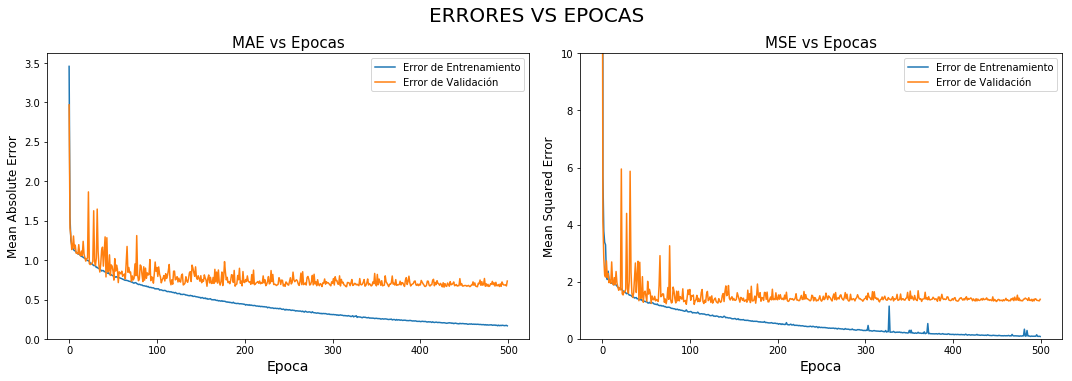

In [198]:
#Entrenamiento con los parámetros cambiados
EPOCHS = 500
model_early_stop = build_model()

#El parámetro patience es el número de épocas que esperaremos para una mejora
early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=25)

history = model2.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.3, verbose=1, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [202]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model2.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.74
Mean Square Error, del conjunto de Test:  1.39


In [203]:
# Generando las predicciones
y_predict = model2.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[-2.065794    0.59305155]
 [-0.5109509   1.5052886 ]
 [-0.81066555  2.4787843 ]
 [-0.6470134   1.7156546 ]
 [-1.680357    1.7981564 ]]
Valores Reales
[[ 0.23624189  0.36066225]
 [-0.30033259  0.84725319]
 [-0.46081619  2.56209755]
 [ 0.98577492  1.9117797 ]
 [-1.90603035  1.40997404]]


In [204]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.091459,0.397058
MSE,2.525013,0.261816
RMSE,1.589029,0.511680
MAPE,394.603436,58.958143
MAXE,6.534159,2.268496


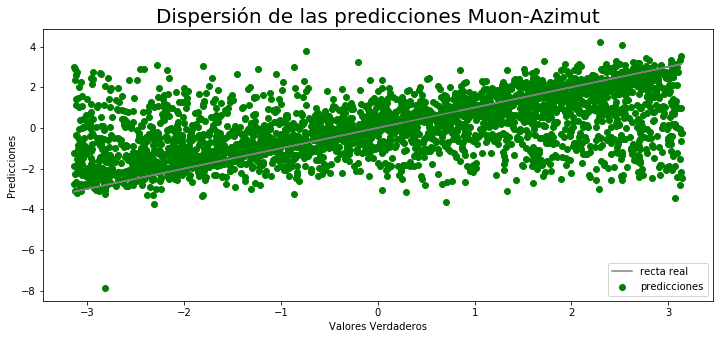

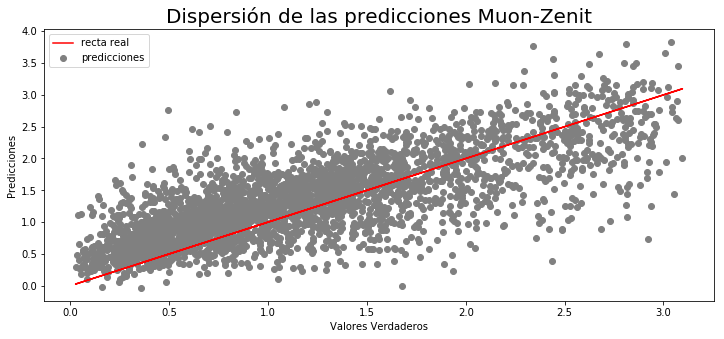

In [205]:
#Graficando las dispersiones
graf_disp()

In [207]:
#Probando el mismo modelo pero con un learning rate diferente
lr = 0.00001
model2 = build_model_2(lr)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 512)               7168      
_________________________________________________________________
dense_93 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_95 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_96 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_97 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_98 (Dense)             (None, 2)                 1026      
Total para

Train on 4900 samples, validate on 2100 samples
Epoch 1/1000
4900/4900 [==============================] - 1s 293us/sample - loss: 6.1218 - mean_absolute_error: 1.5728 - mean_squared_error: 6.1218 - val_loss: 6.1630 - val_mean_absolute_error: 1.6635 - val_mean_squared_error: 6.1630
Epoch 2/1000
4900/4900 [==============================] - 1s 194us/sample - loss: 4.6089 - mean_absolute_error: 1.4800 - mean_squared_error: 4.6089 - val_loss: 4.0977 - val_mean_absolute_error: 1.5826 - val_mean_squared_error: 4.0977
Epoch 3/1000
4900/4900 [==============================] - 1s 194us/sample - loss: 4.0416 - mean_absolute_error: 1.4125 - mean_squared_error: 4.0416 - val_loss: 14.1473 - val_mean_absolute_error: 2.7945 - val_mean_squared_error: 14.1473
Epoch 4/1000
4900/4900 [==============================] - 1s 195us/sample - loss: 4.1512 - mean_absolute_error: 1.3461 - mean_squared_error: 4.1512 - val_loss: 2.3385 - val_mean_absolute_error: 1.1975 - val_mean_squared_error: 2.3385
Epoch 5/1000
4

Epoch 70/1000
4900/4900 [==============================] - 1s 204us/sample - loss: 1.5797 - mean_absolute_error: 0.8954 - mean_squared_error: 1.5797 - val_loss: 1.6187 - val_mean_absolute_error: 0.9269 - val_mean_squared_error: 1.6187
Epoch 71/1000
4900/4900 [==============================] - 1s 196us/sample - loss: 1.5756 - mean_absolute_error: 0.8950 - mean_squared_error: 1.5756 - val_loss: 1.7480 - val_mean_absolute_error: 0.9473 - val_mean_squared_error: 1.7480
Epoch 72/1000
4900/4900 [==============================] - 1s 191us/sample - loss: 1.5419 - mean_absolute_error: 0.8944 - mean_squared_error: 1.5419 - val_loss: 1.5471 - val_mean_absolute_error: 0.9006 - val_mean_squared_error: 1.5471
Epoch 73/1000
4900/4900 [==============================] - 1s 202us/sample - loss: 1.5600 - mean_absolute_error: 0.8912 - mean_squared_error: 1.5600 - val_loss: 1.4920 - val_mean_absolute_error: 0.8862 - val_mean_squared_error: 1.4920
Epoch 74/1000
4900/4900 [==============================] - 1

Epoch 139/1000
4900/4900 [==============================] - 1s 196us/sample - loss: 1.1836 - mean_absolute_error: 0.7422 - mean_squared_error: 1.1836 - val_loss: 1.5934 - val_mean_absolute_error: 0.8786 - val_mean_squared_error: 1.5934
Epoch 140/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 1.2356 - mean_absolute_error: 0.7509 - mean_squared_error: 1.2356 - val_loss: 1.3453 - val_mean_absolute_error: 0.7953 - val_mean_squared_error: 1.3453
Epoch 141/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 1.1449 - mean_absolute_error: 0.7279 - mean_squared_error: 1.1449 - val_loss: 1.3130 - val_mean_absolute_error: 0.7828 - val_mean_squared_error: 1.3130
Epoch 142/1000
4900/4900 [==============================] - 1s 208us/sample - loss: 1.1831 - mean_absolute_error: 0.7407 - mean_squared_error: 1.1831 - val_loss: 1.3330 - val_mean_absolute_error: 0.7948 - val_mean_squared_error: 1.3330
Epoch 143/1000
4900/4900 [==============================

Epoch 174/1000
4900/4900 [==============================] - 1s 199us/sample - loss: 1.0656 - mean_absolute_error: 0.6936 - mean_squared_error: 1.0656 - val_loss: 1.5890 - val_mean_absolute_error: 0.9117 - val_mean_squared_error: 1.5890
Epoch 175/1000
4900/4900 [==============================] - 1s 197us/sample - loss: 1.0912 - mean_absolute_error: 0.6915 - mean_squared_error: 1.0912 - val_loss: 1.7120 - val_mean_absolute_error: 0.9267 - val_mean_squared_error: 1.7120
Epoch 176/1000
4900/4900 [==============================] - 1s 194us/sample - loss: 1.0841 - mean_absolute_error: 0.6977 - mean_squared_error: 1.0841 - val_loss: 1.4906 - val_mean_absolute_error: 0.8539 - val_mean_squared_error: 1.4906
Epoch 177/1000
4900/4900 [==============================] - 1s 197us/sample - loss: 1.0758 - mean_absolute_error: 0.6934 - mean_squared_error: 1.0758 - val_loss: 1.4149 - val_mean_absolute_error: 0.7987 - val_mean_squared_error: 1.4149
Epoch 178/1000
4900/4900 [==============================

Epoch 208/1000
4900/4900 [==============================] - 1s 202us/sample - loss: 1.0022 - mean_absolute_error: 0.6634 - mean_squared_error: 1.0022 - val_loss: 1.2658 - val_mean_absolute_error: 0.7522 - val_mean_squared_error: 1.2658
Epoch 209/1000
4900/4900 [==============================] - 1s 195us/sample - loss: 1.0327 - mean_absolute_error: 0.6592 - mean_squared_error: 1.0327 - val_loss: 1.7496 - val_mean_absolute_error: 0.8978 - val_mean_squared_error: 1.7496
Epoch 210/1000
4900/4900 [==============================] - 1s 192us/sample - loss: 1.0010 - mean_absolute_error: 0.6592 - mean_squared_error: 1.0010 - val_loss: 1.4206 - val_mean_absolute_error: 0.8332 - val_mean_squared_error: 1.4206
Epoch 211/1000
4900/4900 [==============================] - 1s 199us/sample - loss: 0.9881 - mean_absolute_error: 0.6558 - mean_squared_error: 0.9881 - val_loss: 1.3742 - val_mean_absolute_error: 0.7565 - val_mean_squared_error: 1.3742
Epoch 212/1000
4900/4900 [==============================

Epoch 243/1000
4900/4900 [==============================] - 1s 193us/sample - loss: 0.9406 - mean_absolute_error: 0.6310 - mean_squared_error: 0.9406 - val_loss: 1.4902 - val_mean_absolute_error: 0.7988 - val_mean_squared_error: 1.4902
Epoch 244/1000
4900/4900 [==============================] - 1s 198us/sample - loss: 0.9553 - mean_absolute_error: 0.6334 - mean_squared_error: 0.9553 - val_loss: 1.2892 - val_mean_absolute_error: 0.7291 - val_mean_squared_error: 1.2892
Epoch 245/1000
4900/4900 [==============================] - 1s 187us/sample - loss: 0.9380 - mean_absolute_error: 0.6280 - mean_squared_error: 0.9380 - val_loss: 1.4789 - val_mean_absolute_error: 0.8767 - val_mean_squared_error: 1.4789
Epoch 246/1000
4900/4900 [==============================] - 1s 199us/sample - loss: 0.9352 - mean_absolute_error: 0.6299 - mean_squared_error: 0.9352 - val_loss: 1.2673 - val_mean_absolute_error: 0.7076 - val_mean_squared_error: 1.2673
Epoch 247/1000
4900/4900 [==============================

Epoch 278/1000
4900/4900 [==============================] - 1s 198us/sample - loss: 0.8701 - mean_absolute_error: 0.6034 - mean_squared_error: 0.8701 - val_loss: 1.3529 - val_mean_absolute_error: 0.7201 - val_mean_squared_error: 1.3529
Epoch 279/1000
4900/4900 [==============================] - 1s 193us/sample - loss: 0.8999 - mean_absolute_error: 0.6081 - mean_squared_error: 0.8999 - val_loss: 1.7512 - val_mean_absolute_error: 0.8950 - val_mean_squared_error: 1.7512
Epoch 280/1000
4900/4900 [==============================] - 1s 192us/sample - loss: 0.8648 - mean_absolute_error: 0.6055 - mean_squared_error: 0.8648 - val_loss: 1.4453 - val_mean_absolute_error: 0.8125 - val_mean_squared_error: 1.4453
Epoch 281/1000
4900/4900 [==============================] - 1s 193us/sample - loss: 0.8583 - mean_absolute_error: 0.6007 - mean_squared_error: 0.8583 - val_loss: 1.4833 - val_mean_absolute_error: 0.8111 - val_mean_squared_error: 1.4833
Epoch 282/1000
4900/4900 [==============================

Epoch 312/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.8291 - mean_absolute_error: 0.5820 - mean_squared_error: 0.8291 - val_loss: 2.3401 - val_mean_absolute_error: 1.1460 - val_mean_squared_error: 2.3401
Epoch 313/1000
4900/4900 [==============================] - 1s 192us/sample - loss: 0.8332 - mean_absolute_error: 0.5817 - mean_squared_error: 0.8332 - val_loss: 1.3358 - val_mean_absolute_error: 0.7117 - val_mean_squared_error: 1.3358
Epoch 314/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.8060 - mean_absolute_error: 0.5808 - mean_squared_error: 0.8060 - val_loss: 2.0600 - val_mean_absolute_error: 1.0852 - val_mean_squared_error: 2.0600
Epoch 315/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.8303 - mean_absolute_error: 0.5795 - mean_squared_error: 0.8303 - val_loss: 1.3527 - val_mean_absolute_error: 0.7154 - val_mean_squared_error: 1.3527
Epoch 316/1000
4900/4900 [==============================

Epoch 347/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.7876 - mean_absolute_error: 0.5602 - mean_squared_error: 0.7876 - val_loss: 1.3885 - val_mean_absolute_error: 0.7457 - val_mean_squared_error: 1.3885
Epoch 348/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.7803 - mean_absolute_error: 0.5619 - mean_squared_error: 0.7803 - val_loss: 1.7073 - val_mean_absolute_error: 0.8690 - val_mean_squared_error: 1.7073
Epoch 349/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.7751 - mean_absolute_error: 0.5577 - mean_squared_error: 0.7751 - val_loss: 1.3689 - val_mean_absolute_error: 0.7251 - val_mean_squared_error: 1.3689
Epoch 350/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.7709 - mean_absolute_error: 0.5532 - mean_squared_error: 0.7709 - val_loss: 1.4530 - val_mean_absolute_error: 0.7703 - val_mean_squared_error: 1.4530
Epoch 351/1000
4900/4900 [==============================

Epoch 382/1000
4900/4900 [==============================] - 1s 182us/sample - loss: 0.7367 - mean_absolute_error: 0.5421 - mean_squared_error: 0.7367 - val_loss: 1.5248 - val_mean_absolute_error: 0.7804 - val_mean_squared_error: 1.5248
Epoch 383/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.7621 - mean_absolute_error: 0.5378 - mean_squared_error: 0.7621 - val_loss: 1.6266 - val_mean_absolute_error: 0.7614 - val_mean_squared_error: 1.6266
Epoch 384/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.7302 - mean_absolute_error: 0.5359 - mean_squared_error: 0.7302 - val_loss: 1.4056 - val_mean_absolute_error: 0.7466 - val_mean_squared_error: 1.4056
Epoch 385/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.7302 - mean_absolute_error: 0.5343 - mean_squared_error: 0.7302 - val_loss: 1.7995 - val_mean_absolute_error: 0.9080 - val_mean_squared_error: 1.7995
Epoch 386/1000
4900/4900 [==============================

Epoch 451/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.6616 - mean_absolute_error: 0.5072 - mean_squared_error: 0.6616 - val_loss: 1.3870 - val_mean_absolute_error: 0.7120 - val_mean_squared_error: 1.3870
Epoch 452/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.6612 - mean_absolute_error: 0.5068 - mean_squared_error: 0.6612 - val_loss: 1.6065 - val_mean_absolute_error: 0.8220 - val_mean_squared_error: 1.6065
Epoch 453/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.6548 - mean_absolute_error: 0.5084 - mean_squared_error: 0.6548 - val_loss: 1.4733 - val_mean_absolute_error: 0.7342 - val_mean_squared_error: 1.4733
Epoch 454/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.6473 - mean_absolute_error: 0.4980 - mean_squared_error: 0.6473 - val_loss: 1.5315 - val_mean_absolute_error: 0.7703 - val_mean_squared_error: 1.5315
Epoch 455/1000
4900/4900 [==============================

Epoch 486/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.6231 - mean_absolute_error: 0.4897 - mean_squared_error: 0.6231 - val_loss: 1.6120 - val_mean_absolute_error: 0.7312 - val_mean_squared_error: 1.6120
Epoch 487/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.6282 - mean_absolute_error: 0.4849 - mean_squared_error: 0.6282 - val_loss: 1.9419 - val_mean_absolute_error: 0.8786 - val_mean_squared_error: 1.9419
Epoch 488/1000
4900/4900 [==============================] - 1s 182us/sample - loss: 0.6334 - mean_absolute_error: 0.4908 - mean_squared_error: 0.6334 - val_loss: 1.5557 - val_mean_absolute_error: 0.7770 - val_mean_squared_error: 1.5557
Epoch 489/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.6194 - mean_absolute_error: 0.4883 - mean_squared_error: 0.6194 - val_loss: 1.4989 - val_mean_absolute_error: 0.7187 - val_mean_squared_error: 1.4989
Epoch 490/1000
4900/4900 [==============================

Epoch 555/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.5710 - mean_absolute_error: 0.4657 - mean_squared_error: 0.5710 - val_loss: 1.6087 - val_mean_absolute_error: 0.7845 - val_mean_squared_error: 1.6087
Epoch 556/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.5622 - mean_absolute_error: 0.4663 - mean_squared_error: 0.5622 - val_loss: 1.8245 - val_mean_absolute_error: 0.8538 - val_mean_squared_error: 1.8245
Epoch 557/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.5660 - mean_absolute_error: 0.4621 - mean_squared_error: 0.5660 - val_loss: 1.6208 - val_mean_absolute_error: 0.7455 - val_mean_squared_error: 1.6208
Epoch 558/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.5578 - mean_absolute_error: 0.4595 - mean_squared_error: 0.5578 - val_loss: 1.8309 - val_mean_absolute_error: 0.8092 - val_mean_squared_error: 1.8309
Epoch 559/1000
4900/4900 [==============================

Epoch 590/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.5392 - mean_absolute_error: 0.4499 - mean_squared_error: 0.5392 - val_loss: 1.6079 - val_mean_absolute_error: 0.7245 - val_mean_squared_error: 1.6079
Epoch 591/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.5275 - mean_absolute_error: 0.4490 - mean_squared_error: 0.5275 - val_loss: 1.5881 - val_mean_absolute_error: 0.7839 - val_mean_squared_error: 1.5881
Epoch 592/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.5560 - mean_absolute_error: 0.4565 - mean_squared_error: 0.5560 - val_loss: 1.6494 - val_mean_absolute_error: 0.8203 - val_mean_squared_error: 1.6494
Epoch 593/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.5417 - mean_absolute_error: 0.4443 - mean_squared_error: 0.5417 - val_loss: 1.6662 - val_mean_absolute_error: 0.7745 - val_mean_squared_error: 1.6662
Epoch 594/1000
4900/4900 [==============================

Epoch 659/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.4887 - mean_absolute_error: 0.4274 - mean_squared_error: 0.4887 - val_loss: 1.6090 - val_mean_absolute_error: 0.8147 - val_mean_squared_error: 1.6090
Epoch 660/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.4852 - mean_absolute_error: 0.4248 - mean_squared_error: 0.4852 - val_loss: 1.4969 - val_mean_absolute_error: 0.7095 - val_mean_squared_error: 1.4969
Epoch 661/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.4887 - mean_absolute_error: 0.4238 - mean_squared_error: 0.4887 - val_loss: 1.6575 - val_mean_absolute_error: 0.8242 - val_mean_squared_error: 1.6575
Epoch 662/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.4975 - mean_absolute_error: 0.4267 - mean_squared_error: 0.4975 - val_loss: 1.5250 - val_mean_absolute_error: 0.7363 - val_mean_squared_error: 1.5250
Epoch 663/1000
4900/4900 [==============================

Epoch 694/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.4562 - mean_absolute_error: 0.4100 - mean_squared_error: 0.4562 - val_loss: 1.5692 - val_mean_absolute_error: 0.7494 - val_mean_squared_error: 1.5692
Epoch 695/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.4689 - mean_absolute_error: 0.4147 - mean_squared_error: 0.4689 - val_loss: 1.5175 - val_mean_absolute_error: 0.7431 - val_mean_squared_error: 1.5175
Epoch 696/1000
4900/4900 [==============================] - 1s 182us/sample - loss: 0.4586 - mean_absolute_error: 0.4128 - mean_squared_error: 0.4586 - val_loss: 1.5435 - val_mean_absolute_error: 0.7495 - val_mean_squared_error: 1.5435
Epoch 697/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.4649 - mean_absolute_error: 0.4121 - mean_squared_error: 0.4649 - val_loss: 1.5506 - val_mean_absolute_error: 0.8024 - val_mean_squared_error: 1.5506
Epoch 698/1000
4900/4900 [==============================

Epoch 763/1000
4900/4900 [==============================] - 1s 188us/sample - loss: 0.4425 - mean_absolute_error: 0.3934 - mean_squared_error: 0.4425 - val_loss: 1.5781 - val_mean_absolute_error: 0.7798 - val_mean_squared_error: 1.5781
Epoch 764/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.4161 - mean_absolute_error: 0.3918 - mean_squared_error: 0.4161 - val_loss: 1.7556 - val_mean_absolute_error: 0.8294 - val_mean_squared_error: 1.7556
Epoch 765/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.4238 - mean_absolute_error: 0.3954 - mean_squared_error: 0.4238 - val_loss: 1.5419 - val_mean_absolute_error: 0.7389 - val_mean_squared_error: 1.5419
Epoch 766/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.4216 - mean_absolute_error: 0.3943 - mean_squared_error: 0.4216 - val_loss: 1.4578 - val_mean_absolute_error: 0.6988 - val_mean_squared_error: 1.4578
Epoch 767/1000
4900/4900 [==============================

Epoch 798/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.4039 - mean_absolute_error: 0.3818 - mean_squared_error: 0.4039 - val_loss: 1.6452 - val_mean_absolute_error: 0.8071 - val_mean_squared_error: 1.6452
Epoch 799/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.3850 - mean_absolute_error: 0.3784 - mean_squared_error: 0.3850 - val_loss: 1.6451 - val_mean_absolute_error: 0.8598 - val_mean_squared_error: 1.6451
Epoch 800/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.3974 - mean_absolute_error: 0.3846 - mean_squared_error: 0.3974 - val_loss: 1.5186 - val_mean_absolute_error: 0.7234 - val_mean_squared_error: 1.5186
Epoch 801/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.4000 - mean_absolute_error: 0.3843 - mean_squared_error: 0.4000 - val_loss: 1.6133 - val_mean_absolute_error: 0.7658 - val_mean_squared_error: 1.6133
Epoch 802/1000
4900/4900 [==============================

Epoch 867/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3620 - mean_absolute_error: 0.3594 - mean_squared_error: 0.3620 - val_loss: 1.5719 - val_mean_absolute_error: 0.7863 - val_mean_squared_error: 1.5719
Epoch 868/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.3617 - mean_absolute_error: 0.3642 - mean_squared_error: 0.3617 - val_loss: 1.5092 - val_mean_absolute_error: 0.7352 - val_mean_squared_error: 1.5092
Epoch 869/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3698 - mean_absolute_error: 0.3658 - mean_squared_error: 0.3698 - val_loss: 1.5720 - val_mean_absolute_error: 0.7537 - val_mean_squared_error: 1.5720
Epoch 870/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3672 - mean_absolute_error: 0.3618 - mean_squared_error: 0.3672 - val_loss: 1.5976 - val_mean_absolute_error: 0.7873 - val_mean_squared_error: 1.5976
Epoch 871/1000
4900/4900 [==============================

Epoch 902/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3506 - mean_absolute_error: 0.3571 - mean_squared_error: 0.3506 - val_loss: 1.4950 - val_mean_absolute_error: 0.7180 - val_mean_squared_error: 1.4950
Epoch 903/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3556 - mean_absolute_error: 0.3583 - mean_squared_error: 0.3556 - val_loss: 1.5956 - val_mean_absolute_error: 0.7799 - val_mean_squared_error: 1.5956
Epoch 904/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.3477 - mean_absolute_error: 0.3526 - mean_squared_error: 0.3477 - val_loss: 1.6391 - val_mean_absolute_error: 0.7799 - val_mean_squared_error: 1.6391
Epoch 905/1000
4900/4900 [==============================] - 1s 182us/sample - loss: 0.3620 - mean_absolute_error: 0.3562 - mean_squared_error: 0.3620 - val_loss: 1.8081 - val_mean_absolute_error: 0.8487 - val_mean_squared_error: 1.8081
Epoch 906/1000
4900/4900 [==============================

Epoch 937/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.3319 - mean_absolute_error: 0.3502 - mean_squared_error: 0.3319 - val_loss: 1.7177 - val_mean_absolute_error: 0.8146 - val_mean_squared_error: 1.7177
Epoch 938/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3305 - mean_absolute_error: 0.3465 - mean_squared_error: 0.3305 - val_loss: 1.6178 - val_mean_absolute_error: 0.7813 - val_mean_squared_error: 1.6178
Epoch 939/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3297 - mean_absolute_error: 0.3436 - mean_squared_error: 0.3297 - val_loss: 1.6225 - val_mean_absolute_error: 0.7721 - val_mean_squared_error: 1.6225
Epoch 940/1000
4900/4900 [==============================] - 1s 186us/sample - loss: 0.3379 - mean_absolute_error: 0.3481 - mean_squared_error: 0.3379 - val_loss: 1.6899 - val_mean_absolute_error: 0.8268 - val_mean_squared_error: 1.6899
Epoch 941/1000
4900/4900 [==============================

Epoch 972/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.3198 - mean_absolute_error: 0.3426 - mean_squared_error: 0.3198 - val_loss: 2.0608 - val_mean_absolute_error: 0.9825 - val_mean_squared_error: 2.0608
Epoch 973/1000
4900/4900 [==============================] - 1s 185us/sample - loss: 0.3157 - mean_absolute_error: 0.3372 - mean_squared_error: 0.3157 - val_loss: 1.5989 - val_mean_absolute_error: 0.7699 - val_mean_squared_error: 1.5989
Epoch 974/1000
4900/4900 [==============================] - 1s 183us/sample - loss: 0.3131 - mean_absolute_error: 0.3388 - mean_squared_error: 0.3131 - val_loss: 1.6985 - val_mean_absolute_error: 0.7748 - val_mean_squared_error: 1.6985
Epoch 975/1000
4900/4900 [==============================] - 1s 184us/sample - loss: 0.3239 - mean_absolute_error: 0.3406 - mean_squared_error: 0.3239 - val_loss: 1.7133 - val_mean_absolute_error: 0.8323 - val_mean_squared_error: 1.7133
Epoch 976/1000
4900/4900 [==============================

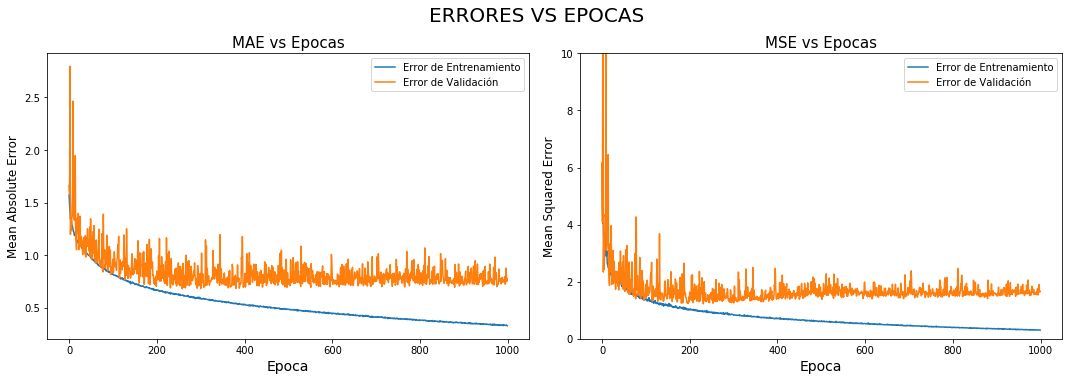

In [208]:
#Entrenamiento con los parámetros cambiados
EPOCHS = 1000
model_early_stop = build_model()

#El parámetro patience es el número de épocas que esperaremos para una mejora
early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=25)

history = model2.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.3, verbose=1, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [209]:
#Verificando que tan bien generaliza el modelo y evaluando 
#las métricas de error: loss, mae y mse, para el modelo sobre el conjunto de test

loss, mae, mse = model2.evaluate(test_dataset, test_labels, verbose=0)

print("Mean Abs Error, del conjunto de Test: {:5.2f}".format(mae))
print("Mean Square Error, del conjunto de Test: {:5.2f}".format(mse))

Mean Abs Error, del conjunto de Test:  0.81
Mean Square Error, del conjunto de Test:  2.00


In [210]:
# Generando las predicciones
y_predict = model2.predict(X_test)

#Comparando algunas predicciones vs valores reales
print("Valores Predichos")
print(y_predict[0:5])
print("Valores Reales")
print(Y_test.iloc[0:5].values)

Valores Predichos
[[-1.3767376  0.2739039]
 [-0.5899074  1.147879 ]
 [-0.9834526  1.5745202]
 [ 0.278697   1.6785154]
 [-2.8762465  1.1832345]]
Valores Reales
[[ 0.23624189  0.36066225]
 [-0.30033259  0.84725319]
 [-0.46081619  2.56209755]
 [ 0.98577492  1.9117797 ]
 [-1.90603035  1.40997404]]


In [211]:
#Obteniendo métricas
mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz = metricas(Y_test.iloc[:,0],y_predict[:,0])
mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze = metricas(Y_test.iloc[:,1],y_predict[:,1])

row_maz = [mae_maz,mse_maz,rmse_maz,mape_maz,maxe_maz]
row_mze = [mae_mze,mse_mze,rmse_mze,mape_mze,maxe_mze]

data_errors = [row_maz,row_mze]

met_df = pd.DataFrame(data_errors, columns=['MAE','MSE','RMSE','MAPE','MAXE'])

print("\nMétricas de error, 0=Muon_Azimut, 1=Muon_Zenit")
met_df.transpose()


Métricas de error, 0=Muon_Azimut, 1=Muon_Zenit


,0,1
MAE,1.221358,0.397272
MSE,3.475572,0.532317
RMSE,1.864289,0.729601
MAPE,358.289034,47.732690
MAXE,32.861212,17.271147


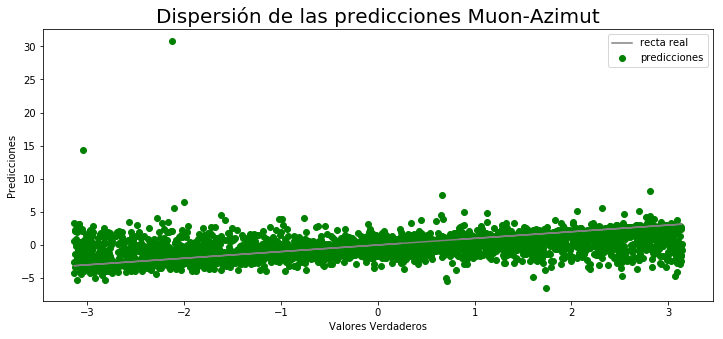

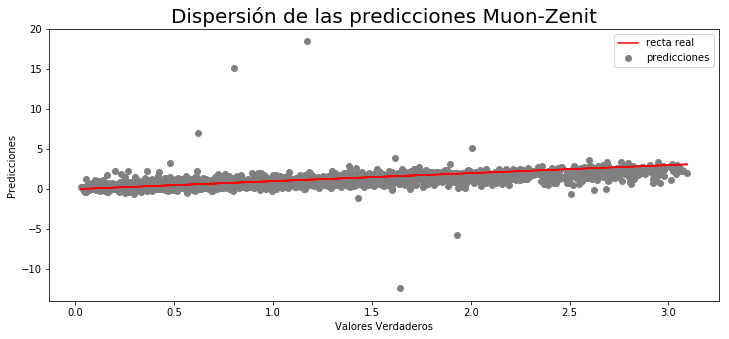

In [212]:
#Graficando las dispersiones
graf_disp()